## Setup

Load libraries:

In [102]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

import xgboost as xgb
import statsmodels.api as sm
import category_encoders as ce
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [103]:
import shap
from sklearn import set_config
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import (
    r2_score, 
    silhouette_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import (
    OneHotEncoder,  
    StandardScaler,
    PowerTransformer,
    FunctionTransformer
)



set_config(
    display='diagram',
    transform_output="pandas"
)

SEED=42

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Load Dataset

In [2]:
df = pd.read_excel(io='SDG and ECO health.xlsx',sheet_name='Data')

##### View Dataset

In [4]:
df.info()


df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   452 non-null    object
 1   Country Code   450 non-null    object
 2   Series Name    450 non-null    object
 3   Series Code    450 non-null    object
 4   2000 [YR2000]  450 non-null    object
 5   2001 [YR2001]  450 non-null    object
 6   2002 [YR2002]  450 non-null    object
 7   2003 [YR2003]  450 non-null    object
 8   2004 [YR2004]  450 non-null    object
 9   2005 [YR2005]  450 non-null    object
 10  2006 [YR2006]  450 non-null    object
 11  2007 [YR2007]  450 non-null    object
 12  2008 [YR2008]  450 non-null    object
 13  2009 [YR2009]  450 non-null    object
 14  2010 [YR2010]  450 non-null    object
 15  2011 [YR2011]  450 non-null    object
 16  2012 [YR2012]  450 non-null    object
 17  2013 [YR2013]  450 non-null    object
 18  2014 [YR2014]  450 non-null   

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,9129594818.607492,8936079252.771315,15285592487.423664,17812704626.232372,23552057820.459892,36970901025.203217,...,133401582620.493591,137244439121.373978,87219300384.507172,49840491178.151764,68972769395.627365,77792944471.949432,69309110145.768738,50241368243.631424,65685435100.498566,106713618735.43364
1,Angola,AGO,Adjusted net national income per capita (curre...,NY.ADJ.NNTY.PC.CD,208.216262,266.611472,567.271009,671.205245,693.447951,948.519834,...,3158.544114,3583.800549,3199.012702,2688.630467,2936.850718,2051.814728,1738.059253,1103.908798,..,..
2,Angola,AGO,Consumer price index (2010 = 100),FP.CPI.TOTL,2.909082,7.347208,15.34813,30.423699,43.670818,53.694805,...,136.131179,146.042056,159.702596,208.729629,271.019931,324.222754,379.599042,464.141687,583.67797,..
3,Angola,AGO,"Energy imports, net (% of energy use)",EG.IMP.CONS.ZS,-504.159002,-475.111255,-550.714185,-501.436656,-555.809535,-735.864295,...,-594.546143,-540.997471,..,..,..,..,..,..,..,..
4,Angola,AGO,Exports of goods and services (annual % growth),NE.EXP.GNFS.KD.ZG,..,..,..,-1.3,10.611806,22.93,...,-1.173901,0.704632,-14.689323,-18.395525,24.543677,-7.613972,-17.415172,-6.194934,-10.655895,0.676883


In [5]:
df.tail()

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,Last Updated: 07/25/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

##### Dropping unwanted rows and columns

In [6]:
df_to_clean=df.copy()

#### Drop the last 5 rows

In [8]:
df_to_clean.iloc[:-5]

,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,9129594818.607492,8936079252.771315,15285592487.423664,17812704626.232372,23552057820.459892,36970901025.203217,...,133401582620.493591,137244439121.373978,87219300384.507172,49840491178.151764,68972769395.627365,77792944471.949432,69309110145.768738,50241368243.631424,65685435100.498566,106713618735.43364
1,Angola,AGO,Adjusted net national income per capita (curre...,NY.ADJ.NNTY.PC.CD,208.216262,266.611472,567.271009,671.205245,693.447951,948.519834,...,3158.544114,3583.800549,3199.012702,2688.630467,2936.850718,2051.814728,1738.059253,1103.908798,..,..
2,Angola,AGO,Consumer price index (2010 = 100),FP.CPI.TOTL,2.909082,7.347208,15.34813,30.423699,43.670818,53.694805,...,136.131179,146.042056,159.702596,208.729629,271.019931,324.222754,379.599042,464.141687,583.67797,..
3,Angola,AGO,"Energy imports, net (% of energy use)",EG.IMP.CONS.ZS,-504.159002,-475.111255,-550.714185,-501.436656,-555.809535,-735.864295,...,-594.546143,-540.997471,..,..,..,..,..,..,..,..
4,Angola,AGO,Exports of goods and services (annual % growth),NE.EXP.GNFS.KD.ZG,..,..,..,-1.3,10.611806,22.93,...,-1.173901,0.704632,-14.689323,-18.395525,24.543677,-7.613972,-17.415172,-6.194934,-10.655895,0.676883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Ethiopia,ETH,Electric power transmission and distribution l...,EG.ELC.LOSS.ZS,9.976105,9.99006,9.980431,10.017422,10.003939,10.017575,...,19.018616,18.654756,..,..,..,..,..,..,..,..
446,Ethiopia,ETH,Electricity production from hydroelectric sour...,EG.ELC.HYRO.ZS,98.32736,99.005964,98.972603,99.303136,99.291059,99.578207,...,95.817054,94.72412,92.68947,..,..,..,..,..,..,..
447,Ethiopia,ETH,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,95.55,94.6,94.53,94.23,94.13,94.73,...,92.42,91.16,91.46,90.37,90.2,89.73,89.5,89.52,..,..
448,Ethiopia,ETH,Exports of goods and services (current LCU),NE.EXP.GNFS.CN,..,..,..,..,..,..,...,108227065700,123495977600,121532200000,122501000000,139830000000,184209000000,213645000000,240525000000,331294000000,507692000000


##### Chain the code to Drop the last 5 rows, country code and series code

In [9]:
df_to_clean=(
    df_to_clean
    .iloc[:-5]
    .drop(columns=['Country Code', 'Series Code'])
)

In [10]:
df_to_clean.head()

,Country Name,Series Name,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Angola,GDP (current US$),9129594818.607492,8936079252.771315,15285592487.423664,17812704626.232372,23552057820.459892,36970901025.203217,52381025105.217659,65266415706.974136,...,133401582620.493591,137244439121.373978,87219300384.507172,49840491178.151764,68972769395.627365,77792944471.949432,69309110145.768738,50241368243.631424,65685435100.498566,106713618735.43364
1,Angola,Adjusted net national income per capita (curre...,208.216262,266.611472,567.271009,671.205245,693.447951,948.519834,1291.374119,1435.296003,...,3158.544114,3583.800549,3199.012702,2688.630467,2936.850718,2051.814728,1738.059253,1103.908798,..,..
2,Angola,Consumer price index (2010 = 100),2.909082,7.347208,15.34813,30.423699,43.670818,53.694805,60.839012,68.292702,...,136.131179,146.042056,159.702596,208.729629,271.019931,324.222754,379.599042,464.141687,583.67797,..
3,Angola,"Energy imports, net (% of energy use)",-504.159002,-475.111255,-550.714185,-501.436656,-555.809535,-735.864295,-759.628789,-858.188815,...,-594.546143,-540.997471,..,..,..,..,..,..,..,..
4,Angola,Exports of goods and services (annual % growth),..,..,..,-1.3,10.611806,22.93,14.29,16.56,...,-1.173901,0.704632,-14.689323,-18.395525,24.543677,-7.613972,-17.415172,-6.194934,-10.655895,0.676883


###### Convert data to Long Format for cleaning

In [11]:
df_to_clean_long = df_to_clean.melt(id_vars=['Country Name', 'Series Name'], 
                                    var_name='Year', value_name='Value')

df_to_clean_long.head()

,Country Name,Series Name,Year,Value
0,Angola,GDP (current US$),2000 [YR2000],9129594818.607492
1,Angola,Adjusted net national income per capita (curre...,2000 [YR2000],208.216262
2,Angola,Consumer price index (2010 = 100),2000 [YR2000],2.909082
3,Angola,"Energy imports, net (% of energy use)",2000 [YR2000],-504.159002
4,Angola,Exports of goods and services (annual % growth),2000 [YR2000],..


###### Extract the Years (through regular expression)

In [12]:
df_to_clean_long.Year.str.extract('(\d+)')

,0
0,2000
1,2000
2,2000
3,2000
4,2000
...,...
10345,2022
10346,2022
10347,2022
10348,2022


###### Convert the years to integer and save

In [13]:
df_to_clean_long.Year=df_to_clean_long.Year.str.extract('(\d+)').astype(int)

###### Convert the '...' to NAN (by coercing the error)

In [14]:
pd.to_numeric(df_to_clean_long.Value, errors='coerce')

0        9.129595e+09
1        2.082163e+02
2        2.909082e+00
3       -5.041590e+02
4                 NaN
             ...     
10345             NaN
10346             NaN
10347             NaN
10348    5.076920e+11
10349             NaN
Name: Value, Length: 10350, dtype: float64

In [15]:
df_to_clean_long.Value=pd.to_numeric(df_to_clean_long.Value, errors='coerce')

###### Convert Data to Wide Format for Analysis and view

In [16]:
df_to_clean_long.pivot_table(index=['Country Name', 'Year'], columns='Series Name', values='Value')

Series Name        Adjusted net national income per capita (current US$)  \
Country Name Year                                                          
Angola       2000                                         208.216262       
             2001                                         266.611472       
             2002                                         567.271009       
             2003                                         671.205245       
             2004                                         693.447951       
...                                                              ...       
Zambia       2018                                        1145.844603       
             2019                                         990.129619       
             2020                                         733.301291       
             2021                                                NaN       
             2022                                                NaN       

Series Name        Consumer price index (2010 = 100)  \
Country Name Year                                      
Angola       2000                           2.909082   
             2001                           7.347208   
             2002                          15.348130   
             2003                          30.423699   
             2004                          43.670818   
...                                              ...   
Zambia       2018                         194.510438   
             2019                         212.308759   
             2020                         245.711424   
             2021                         299.818966   
             2022                         332.778677   

Series Name        Electric power transmission and distribution losses (% of output)  \
Country Name Year                                                                      
Angola       2000                                          14.602076                   
             2001                                          14.529915                   
             2002                                          14.617564                   
             2003                                          12.932331                   
             2004                                          26.433692                   
...                                                              ...                   
Zambia       2018                                                NaN                   
             2019                                                NaN                   
             2020                                                NaN                   
             2021                                                NaN                   
             2022                                                NaN                   

Series Name        Electricity production from hydroelectric sources (% of total)  \
Country Name Year                                                                   
Angola       2000                                          63.114187                
             2001                                          62.087912                
             2002                                          64.759207                
             2003                                          62.205514                
             2004                                          78.405018                
...                                                              ...                
Zambia       2018                                                NaN                
             2019                                                NaN                
             2020                                                NaN                
             2021                                                NaN                
             2022                                                NaN                

Series Name        Energy impor

##### Reset index and save

In [17]:
df_to_clean_wide=df_to_clean_long.pivot_table(index=['Country Name', 'Year'],
                                              columns='Series Name', values='Value').reset_index()

In [18]:
df_to_clean_wide.head()

Series Name,Country Name,Year,Adjusted net national income per capita (current US$),Consumer price index (2010 = 100),Electric power transmission and distribution losses (% of output),Electricity production from hydroelectric sources (% of total),"Energy imports, net (% of energy use)",Exports of goods and services (annual % growth),Exports of goods and services (current LCU),Fossil fuel energy consumption (% of total),GDP (current US$),Renewable energy consumption (% of total final energy consumption)
0,Angola,2000,208.216262,2.909082,14.602076,63.114187,-504.159002,NaN,8.221150e+10,25.220052,9.129595e+09,73.44
1,Angola,2001,266.611472,7.347208,14.529915,62.087912,-475.111255,NaN,1.485998e+11,26.679300,8.936079e+09,72.34
2,Angola,2002,567.271009,15.348130,14.617564,64.759207,-550.714185,NaN,3.798350e+11,28.147804,1.528559e+10,70.42
3,Angola,2003,671.205245,30.423699,12.932331,62.205514,-501.436656,-1.300000,7.218980e+11,31.721424,1.781270e+10,65.14
4,Angola,2004,693.447951,43.670818,26.433692,78.405018,-555.809535,10.611806,1.148675e+12,31.561637,2.355206e+10,61.92


##### Check data Info

In [19]:
df_to_clean_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 12 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country Name                                                        1035 non-null   object 
 1   Year                                                                1035 non-null   int64  
 2   Adjusted net national income per capita (current US$)               921 non-null    float64
 3   Consumer price index (2010 = 100)                                   1019 non-null   float64
 4   Electric power transmission and distribution losses (% of output)   662 non-null    float64
 5   Electricity production from hydroelectric sources (% of total)      720 non-null    float64
 6   Energy imports, net (% of energy use)                               687 non-null    float64
 7   Exports of good

##### Check All Country Names

In [20]:
df_to_clean_wide['Country Name'].unique()

array(['Angola', 'Armenia', 'Bangladesh', 'Belarus', 'Benin', 'Bolivia',
       'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia',
       'Congo, Dem. Rep.', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador',
       'Egypt, Arab Rep.', 'Ethiopia', 'Finland', 'France', 'Gabon',
       'Germany', 'Ghana', 'Haiti', 'Hungary', 'Iceland', 'India',
       'Italy', 'Jamaica', 'Japan', 'Mauritius', 'Mexico', 'Morocco',
       'Mozambique', 'Myanmar', 'Nepal', 'Senegal', 'South Africa',
       'Sudan', 'Tanzania', 'Togo', 'United Kingdom', 'United States',
       'Zambia'], dtype=object)

##### confirm the number of countries

In [21]:
len(df_to_clean_wide['Country Name'].unique())

45

##### Group Countries

In [22]:
under_developed=[
    'Angola','Bangladesh','Benin','Cambodia',
    'Mozambique','Sudan','Zambia', 'Congo, Dem. Rep.',
    'Ethiopia', 'Haiti','Myanmar', 'Togo',
    'Tanzania','Mauritius','Nepal',
    
]

developing_countries= [
    'Armenia','Belarus','Bolivia','Bulgaria',
    'Colombia','Costa Rica','Ecuador','Egypt, Arab Rep.',
    'Gabon','Ghana','India','Jamaica','Morocco',
    'Senegal','South Africa',
    
]

developed_countries=[
    'Brazil','Canada','Chile',
    'Croatia','Denmark','Finland','France',
    'Germany','Hungary','Iceland','Italy',
    'Japan','Mexico',
    'United Kingdom','United States',
]

In [23]:
len(under_developed)+len(developing_countries)+len(developed_countries)

45

1. GDP (current US\$) ==> GDP
2. Adjusted net national income per capita (current US$) ==> National Income
3. Consumer price index (2010 = 100) ==> CPI
4. Energy imports, net (% of energy use) ==> Energy_imports
5. Exports of goods and services (annual % growth) ==> Annual_exports
6. Electric power transmission and distribution losses (% of output) ==> Power_transmission
7. Electricity production from hydroelectric sources (% of total) ==> Hydroelectric_power
8. Renewable energy consumption (% of total final energy consumption) ==> REC
9. Exports of goods and services (Current LCU) ==> Exports 
10. Fossil Fuel energy consumption (% of total) ==> Fossil fuel

In [25]:
df_to_clean_wide=\
df_to_clean_wide.rename(
    columns={
        'GDP (current US$)': 'GDP',
        'Adjusted net national income per capita (current US$)': 'National Income',
        'Consumer price index (2010 = 100)': 'CPI',
        'Energy imports, net (% of energy use)': 'Energy_imports',
        'Exports of goods and services (annual % growth)': 'Annual_exports',
        'Electric power transmission and distribution losses (% of output)': 'Power_transmission',
        'Electricity production from hydroelectric sources (% of total)': 'Hydroelectric_power',
        'Renewable energy consumption (% of total final energy consumption)': 'REC',
        'Exports of goods and services (current LCU)': 'Exports',
        'Fossil fuel energy consumption (% of total)':'Fossil fuel',
    }
)

In [26]:
df_to_clean_wide.head()

Series Name,Country Name,Year,National Income,CPI,Power_transmission,Hydroelectric_power,Energy_imports,Annual_exports,Exports,Fossil fuel,GDP,REC
0,Angola,2000,208.216262,2.909082,14.602076,63.114187,-504.159002,NaN,8.221150e+10,25.220052,9.129595e+09,73.44
1,Angola,2001,266.611472,7.347208,14.529915,62.087912,-475.111255,NaN,1.485998e+11,26.679300,8.936079e+09,72.34
2,Angola,2002,567.271009,15.348130,14.617564,64.759207,-550.714185,NaN,3.798350e+11,28.147804,1.528559e+10,70.42
3,Angola,2003,671.205245,30.423699,12.932331,62.205514,-501.436656,-1.300000,7.218980e+11,31.721424,1.781270e+10,65.14
4,Angola,2004,693.447951,43.670818,26.433692,78.405018,-555.809535,10.611806,1.148675e+12,31.561637,2.355206e+10,61.92


##### Check the number of missing observations

In [27]:
df_to_clean_wide.isnull().sum()

Series Name
Country Name             0
Year                     0
National Income        114
CPI                     16
Power_transmission     373
Hydroelectric_power    315
Energy_imports         348
Annual_exports          61
Exports                 26
Fossil fuel            348
GDP                      0
REC                     90
dtype: int64

##### Filling the missing observations using KNN

The KNN approach has three steps:

1. Define the measure of distance
2. FInd the k nearest neighbors: For each point in our dataset that has a missing value, we'll find the `K` closest points (according to the distance metric above) that have the value for that feature.
3. Imputing the missing value: after step 2,  we'll calculate some sort of average of their values to fill the missing one. This sort of average could be simple mean for numerical data, mode for categoical data, or weighted mean where closer neighbors contribute more to the imputed value.

The detailed explanation of this will be provided in the report.

In [28]:
from sklearn.impute import KNNImputer

##### Initialize KNN Imputer

In [29]:
imputer=KNNImputer(n_neighbors=5, weights='distance')

It will be misleading to apply KNN to the DF above (df_to_clean_wide) because the data is organised by countries and as such, each country's data should be treated as an independent time series. The imputation should be performed separately for each country (ie, It should replace based on the value of the country).

Note - By default, SK learns returns result as a numpy array and it is necessary to convert the result back to a dataframe after imputting

In [30]:
# Store the imputed dataframes here and concatenate them at the end
imputed_dfs=[]

# unique countries
countries=df_to_clean_wide['Country Name'].unique()

# Loop over each country to get KNN done
for country in countries:
    #filter the data for the curent country
    data_country=df_to_clean_wide[df_to_clean_wide['Country Name'] ==country]
    
    # Drop the Country Name column for the imputation (it will be added later)
    country_name=data_country['Country Name']
    data_country=data_country.drop(columns='Country Name')
    
    # fit imputer and transfor the data for the current country
    data_country_imputed=imputer.fit_transform(data_country)
    
    # convert the result back to a dataframe and add the 'Country Name' column

    data_country_imputed=pd.DataFrame(data_country_imputed, columns=data_country.columns)
    data_country_imputed['Country Name']=country_name.values
    
    # Append the imputed dataframe
    imputed_dfs.append(data_country_imputed)    

##### Check the current cleaned dataframe info

In [31]:
clean_df=pd.concat(imputed_dfs)
clean_df.Year=clean_df.Year.astype(int)
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035 entries, 0 to 22
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 1035 non-null   int32  
 1   National Income      1035 non-null   float64
 2   CPI                  1035 non-null   float64
 3   Power_transmission   1035 non-null   float64
 4   Hydroelectric_power  1035 non-null   float64
 5   Energy_imports       1035 non-null   float64
 6   Annual_exports       1035 non-null   float64
 7   Exports              1035 non-null   float64
 8   Fossil fuel          1035 non-null   float64
 9   GDP                  1035 non-null   float64
 10  REC                  1035 non-null   float64
 11  Country Name         1035 non-null   object 
dtypes: float64(10), int32(1), object(1)
memory usage: 101.1+ KB


Series Name,Year,National Income,CPI,Power_transmission,Hydroelectric_power,Energy_imports,Annual_exports,Exports,Fossil fuel,GDP,REC,Country Name
0,2000,208.216262,2.909082,14.602076,63.114187,-504.159002,3.495859,8.221150e+10,25.220052,9.129595e+09,73.44,Angola
1,2001,266.611472,7.347208,14.529915,62.087912,-475.111255,3.499982,1.485998e+11,26.679300,8.936079e+09,72.34,Angola
2,2002,567.271009,15.348130,14.617564,64.759207,-550.714185,3.236893,3.798350e+11,28.147804,1.528559e+10,70.42,Angola
3,2003,671.205245,30.423699,12.932331,62.205514,-501.436656,-1.300000,7.218980e+11,31.721424,1.781270e+10,65.14,Angola
4,2004,693.447951,43.670818,26.433692,78.405018,-555.809535,10.611806,1.148675e+12,31.561637,2.355206e+10,61.92,Angola


##### Check if there are still missing observations after applying KNN

In [32]:
clean_df.isnull().sum()

Series Name
Year                   0
National Income        0
CPI                    0
Power_transmission     0
Hydroelectric_power    0
Energy_imports         0
Annual_exports         0
Exports                0
Fossil fuel            0
GDP                    0
REC                    0
Country Name           0
dtype: int64

### More On Exploratory Data Analysis (PLOTTING)

##### Country Class Variable Created for Each Country (Underdeveloped, Developing, Developed)

In [33]:
clean_df['Country Name'].apply(lambda x:'Developed' if x in 
                               developed_countries else('Developing' if x in 
                                                        developing_countries else 'Under-developed'))

0     Under-developed
1     Under-developed
2     Under-developed
3     Under-developed
4     Under-developed
           ...       
18    Under-developed
19    Under-developed
20    Under-developed
21    Under-developed
22    Under-developed
Name: Country Name, Length: 1035, dtype: object

In [34]:
clean_df['Country Class'] = clean_df['Country Name'].\
                                apply(lambda x:'Developed' if x in 
                                      developed_countries else('Developing' if x in 
                                                               developing_countries else 'Under-developed'))

##### Count the Number Of Country Class for Each Country

In [35]:
clean_df[['Country Class', 'Country Name']].drop_duplicates()['Country Class'].value_counts()

Under-developed    15
Developing         15
Developed          15
Name: Country Class, dtype: int64

##### Bar Chart To Show the Distribution Of the Dataset

In [37]:
import seaborn as sns
from matplotlib import pyplot as plt

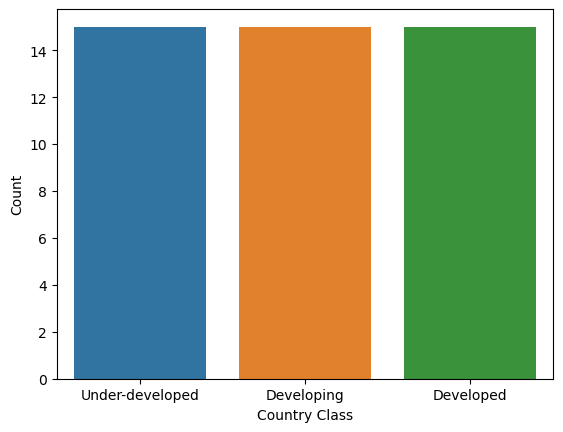

In [38]:
df_country_stats=clean_df[['Country Class', 'Country Name']].drop_duplicates()['Country Class'].value_counts()
status=df_country_stats.index
count=df_country_stats.values

sns.barplot(x=status, y=count)
plt.xlabel('Country Class')
plt.ylabel('Count')
plt.show()

##### Visualisation Showing The Average Hydro Electric By Country Class

In [39]:
clean_df.groupby('Country Class')['Hydroelectric_power'].mean()

Country Class
Developed          24.979901
Developing         29.056626
Under-developed    56.460939
Name: Hydroelectric_power, dtype: float64

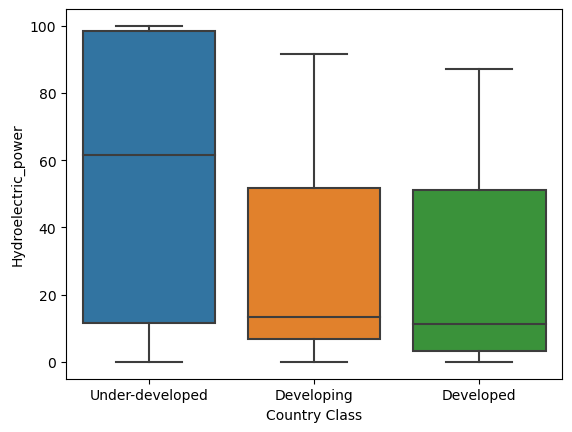

In [40]:
sns.boxplot(x='Country Class', y='Hydroelectric_power', data=clean_df)
plt.show()

##### Average Renewable Energy Consumption By Country Class

In [41]:
clean_df.groupby('Country Class')['REC'].mean()

Country Class
Developed          22.298207
Developing         25.792730
Under-developed    70.918464
Name: REC, dtype: float64

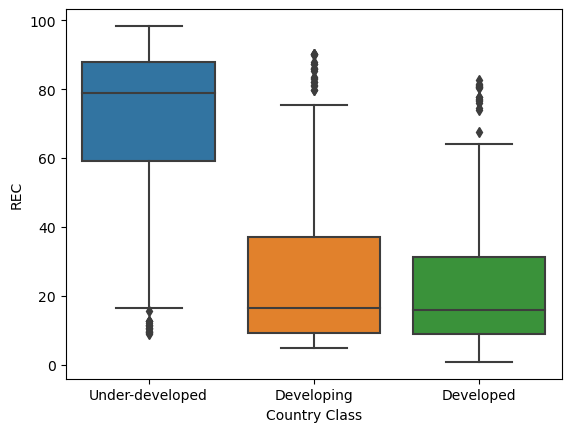

In [42]:
sns.boxplot(x='Country Class', y='REC', data=clean_df)
plt.show()

##### Check How The Renewable Energy Consumption has been moving on Average Over The Years

In [43]:
df_rec_year_class=clean_df.groupby(['Year','Country Class'])['REC'].mean().reset_index()

##### PLOT

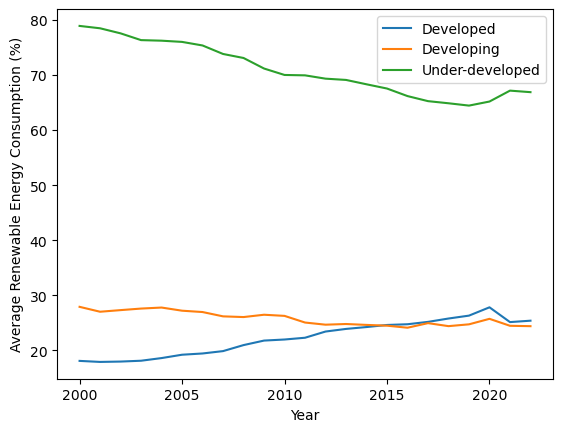

In [44]:
df_rec_year_class=clean_df.groupby(['Year','Country Class'])['REC'].mean().reset_index()

for c in df_rec_year_class['Country Class'].unique():
    data=df_rec_year_class[df_rec_year_class['Country Class'] == c]
    plt.plot(data['Year'], data['REC'], label=c)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Average Renewable Energy Consumption (%)')
plt.show()

##### More On Visualisation - Scatter Plot Showing The Relationship between the variables 


In [45]:
#Check the unique country class to extract
clean_df['Country Class'].unique()

array(['Under-developed', 'Developing', 'Developed'], dtype=object)

In [46]:
dfs= {
        'Under-developed Countries': clean_df[clean_df['Country Class'] == 'Under-developed'],
        'Developed Countries': clean_df[clean_df['Country Class'] == 'Developed'],
        'Developing Countries': clean_df[clean_df['Country Class'] == 'Developing']
}
def plot_scatter_per_class(x_var, y_var):
    
    plt.figure(figsize=(20,6))
    for i,(k,v) in enumerate(dfs.items()):
        plt.subplot(1,3,i+1)
        sns.scatterplot(x=x_var, y=y_var, data = v, edgecolor='black', s=100)
        plt.title(k, fontsize=16)
        plt.xlabel(x_var, fontsize=16)
        plt.ylabel(y_var, fontsize=16)
    plt.tight_layout()
    plt.show()

In [47]:
##### Scatter Plot Showing The Relationship Between SDG 7 Variables and Economic health Variables For Each Country Class

In [48]:
sdg7_indicators=[
    'Hydroelectric_power', 'Power_transmission', 
    'Fossil fuel','REC'
]

economic_health=[
    'National Income', 'CPI',
    'Energy_imports', 'Annual_exports', 'Exports','GDP'
]

In [49]:
dfs= {
        'Under-developed Countries': clean_df[clean_df['Country Class'] == 'Under-developed'],
        'Developed Countries': clean_df[clean_df['Country Class'] == 'Developed'],
        'Developing Countries': clean_df[clean_df['Country Class'] == 'Developing']
}
def plot_scatter_per_class(x_var, y_var):
    
    plt.figure(figsize=(20,6))
    for i,(k,v) in enumerate(dfs.items()):
        plt.subplot(1,3,i+1)
        sns.scatterplot(x=x_var, y=y_var, data = v, edgecolor='black', s=100)
        plt.title(k, fontsize=16)
        plt.xlabel(x_var, fontsize=16)
        plt.ylabel(y_var, fontsize=16)

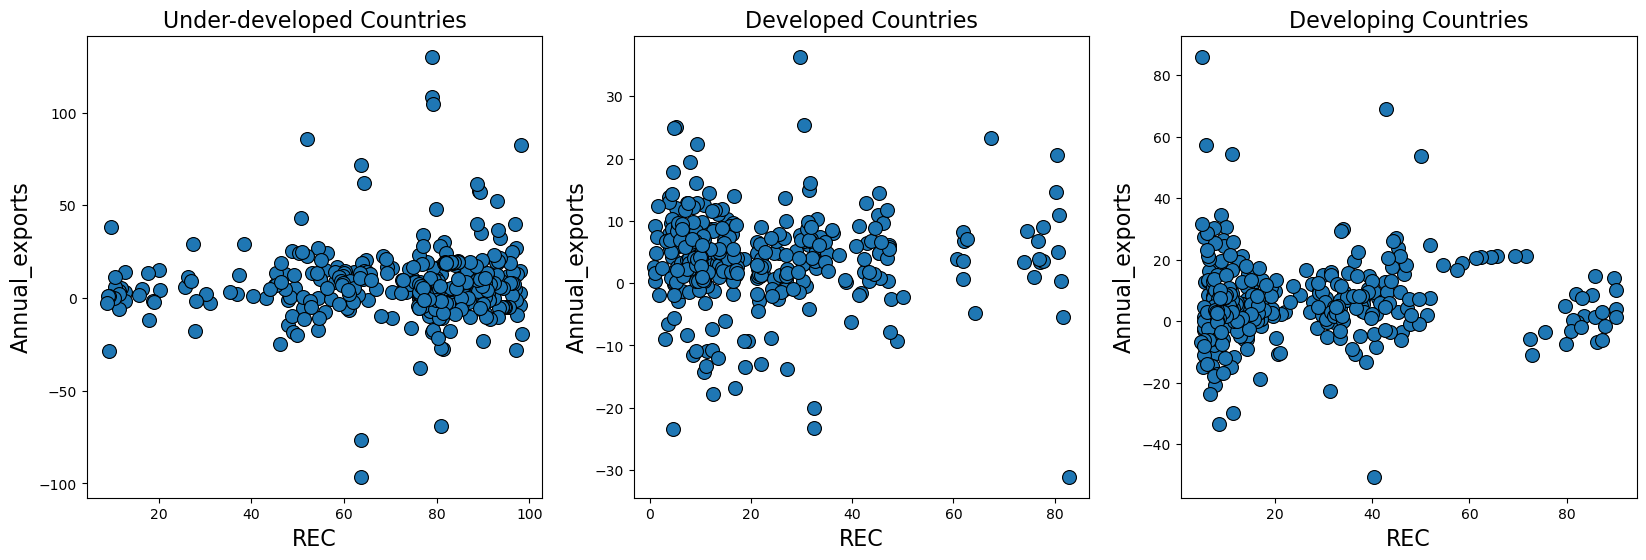

In [50]:
plot_scatter_per_class(x_var='REC', y_var='Annual_exports')

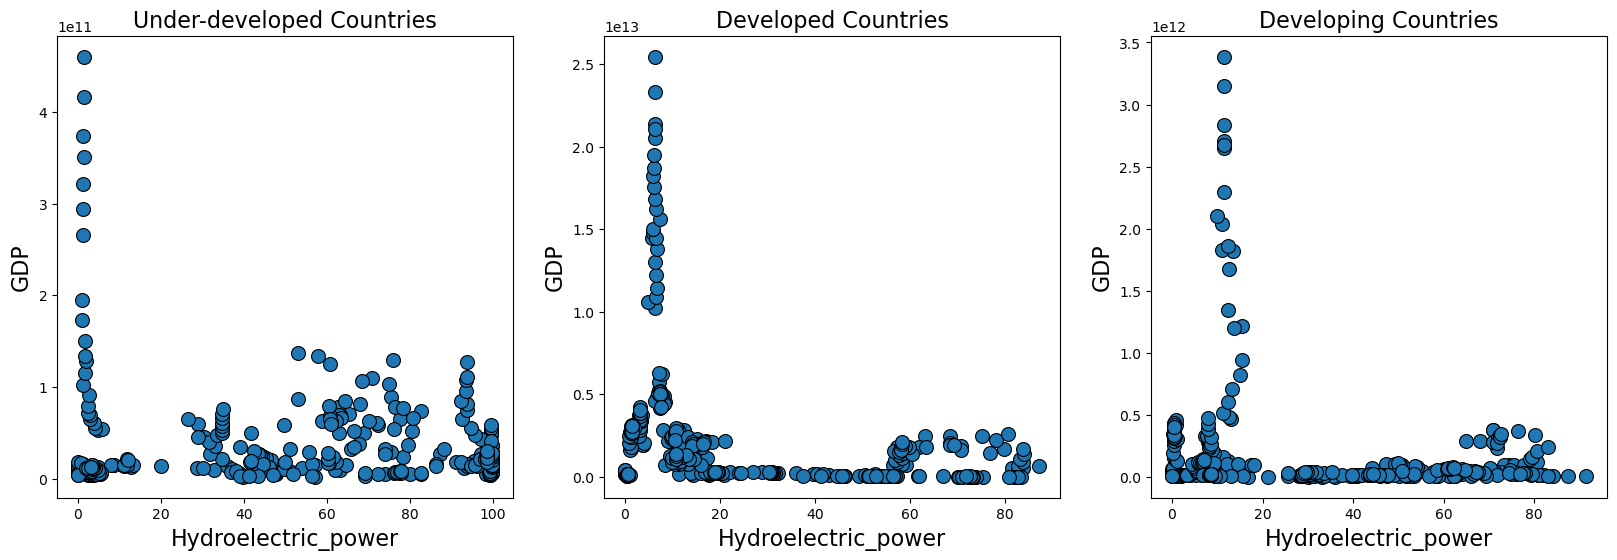

In [51]:
plot_scatter_per_class(x_var='Hydroelectric_power', y_var='GDP')

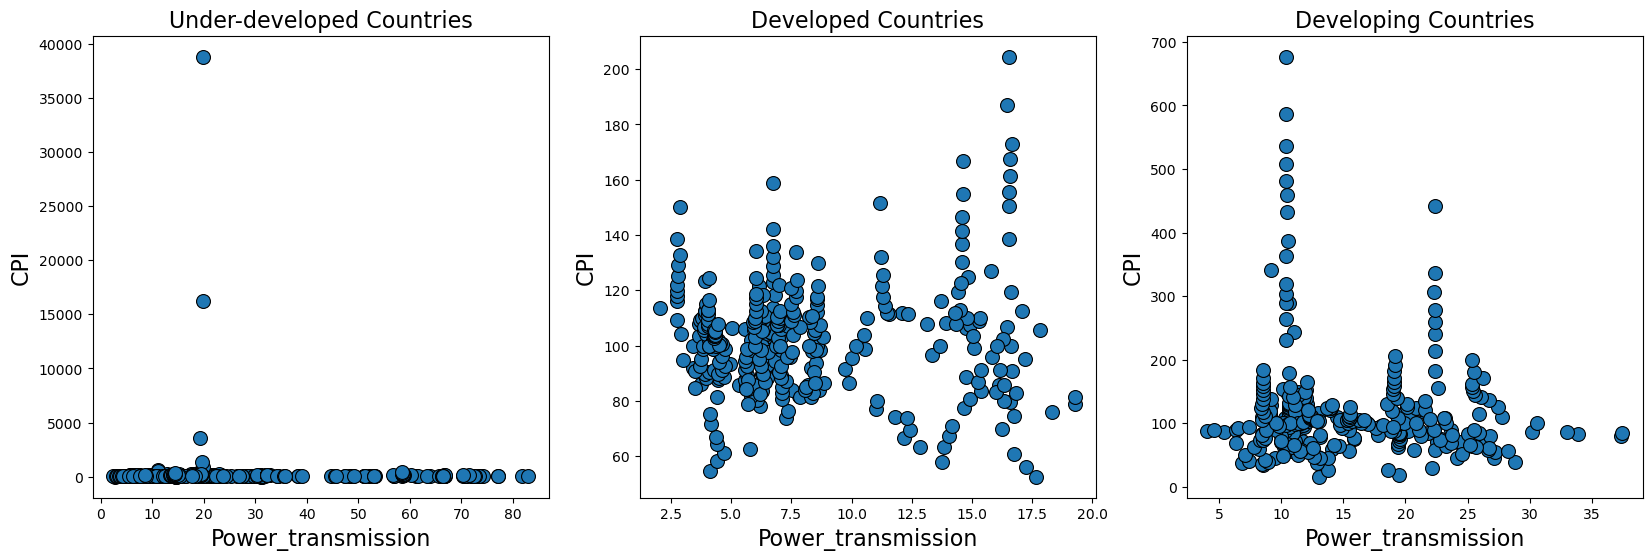

In [52]:
plot_scatter_per_class(x_var='Power_transmission', y_var='CPI')

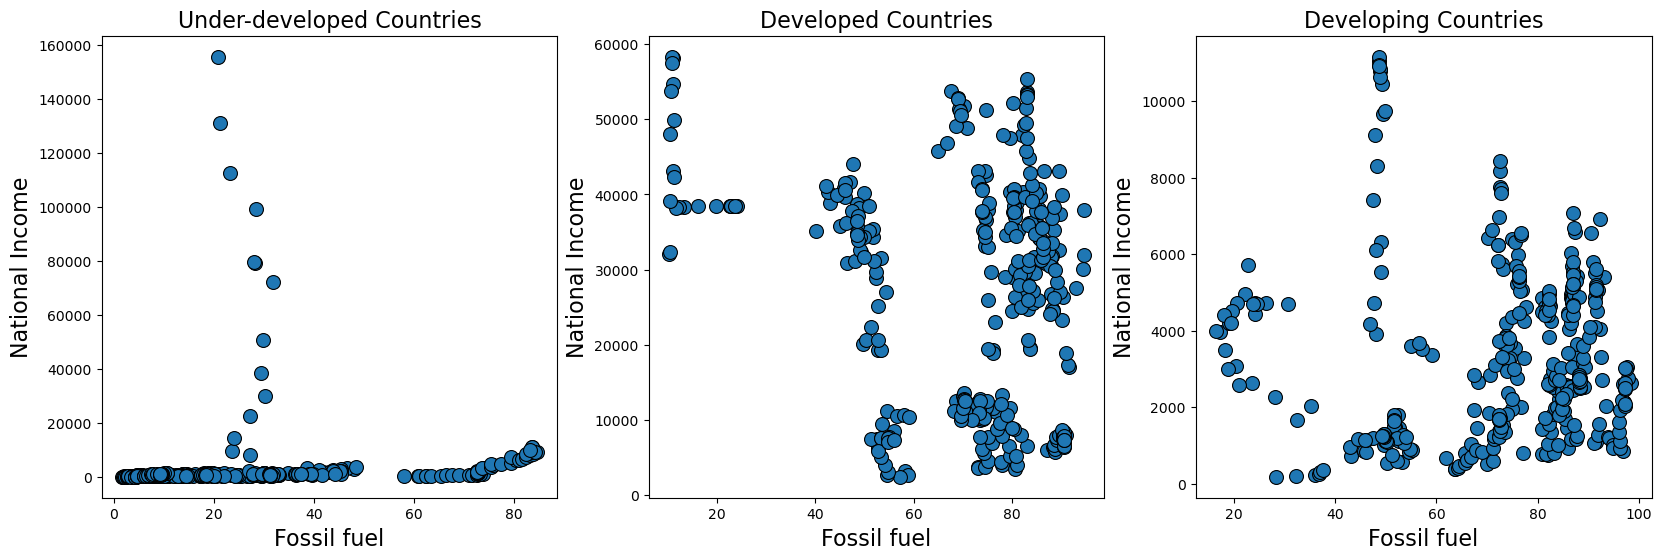

In [53]:
plot_scatter_per_class(x_var='Fossil fuel', y_var='National Income')

## Objective 1
##### Descriptive/Summary Statistics

In [55]:
clean_df.to_csv('for_desc.csv')

In [60]:
for c in ['Developed', 'Developing', 'Under-developed']:
    print(f"SDG7 Descriptive Statistics for {c}:\n")
    display(clean_df[clean_df['Country Class']==c][sdg7_indicators].describe())

SDG7 Descriptive Statistics for Developed:



Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC
count,345.000000,345.000000,345.000000,345.000000
mean,24.979901,8.145629,70.324831,22.298207
std,26.837818,4.286781,19.987984,18.494891
min,0.037418,2.064473,10.254953,0.850000
25%,3.344010,4.543577,56.548892,9.030000
50%,11.190889,6.746291,76.102572,16.040000
75%,51.203281,10.636639,83.621975,31.360000
max,87.243988,19.276834,94.633302,82.790000


SDG7 Descriptive Statistics for Developing:



Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC
count,345.000000,345.000000,345.000000,345.000000
mean,29.056626,15.063953,71.660250,25.792730
std,27.541563,6.246915,20.220050,21.409664
min,0.000000,4.053565,16.462128,4.820000
25%,6.675268,10.415884,54.766523,9.160000
50%,13.232923,12.273652,76.305611,16.550000
75%,51.588310,19.480519,86.919411,37.203360
max,91.499377,37.430168,98.460091,90.120000


SDG7 Descriptive Statistics for Under-developed:



Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC
count,345.000000,345.000000,345.000000,345.000000
mean,56.460939,25.392495,26.332473,70.918464
std,38.097902,20.003202,22.186509,22.532713
min,0.000000,2.432070,1.639733,8.940000
25%,11.689654,11.102166,9.596146,59.200000
50%,61.476895,18.751118,19.420191,78.990000
75%,98.372514,31.301290,32.077444,87.760000
max,99.949850,82.882883,84.542360,98.340000


In [61]:
for c in ['Developed', 'Developing', 'Under-developed']:
    print(f"Economic Health Descriptive Statistics for {c}:\n")
    display(clean_df[clean_df['Country Class']==c][economic_health].describe())

Economic Health Descriptive Statistics for Developed:



Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
count,345.000000,345.000000,345.000000,345.000000,3.450000e+02,3.450000e+02
mean,26763.202911,102.687643,30.439669,3.855579,1.065430e+13,2.444850e+12
std,14856.498246,20.297170,41.167709,7.225919,2.277429e+13,4.120365e+12
min,2401.839817,52.531583,-72.528170,-31.073731,8.391479e+09,8.234847e+09
25%,11220.619364,90.281117,9.094184,1.137638,4.371460e+11,1.974794e+11
50%,30029.819386,102.777290,46.197276,3.983247,8.080220e+11,1.272839e+12
75%,38329.357346,111.192991,60.564510,7.194876,2.539648e+12,2.699660e+12
max,58338.793145,204.482121,93.981260,36.352931,1.019465e+14,2.546270e+13


Economic Health Descriptive Statistics for Developing:



Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
count,345.000000,345.000000,345.000000,345.000000,3.450000e+02,3.450000e+02
mean,3347.137747,118.944298,-27.623580,5.775771,9.863132e+12,1.958944e+11
std,2264.437883,81.857579,142.393436,12.834279,3.153651e+13,4.785112e+11
min,187.654343,16.050606,-929.568436,-50.657322,6.321578e+08,1.911564e+09
25%,1456.344508,78.588772,-117.747253,0.000000,6.208985e+10,1.583077e+10
50%,2836.283688,104.219903,32.514894,4.964336,4.183610e+11,5.094967e+10
75%,4741.166554,126.423331,66.450506,10.050029,2.922798e+12,1.185406e+11
max,11164.911785,676.627748,90.940600,86.043298,2.998358e+14,3.385090e+12


Economic Health Descriptive Statistics for Under-developed:



Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
count,345.000000,345.000000,345.000000,345.000000,3.450000e+02,3.450000e+02
mean,3799.957074,292.798072,-37.394152,7.391830,5.585160e+12,3.684688e+10
std,15634.231110,2262.882204,170.961247,20.187360,1.249742e+13,5.638693e+10
min,64.483956,2.909082,-885.245941,-96.364419,2.679713e+09,2.014517e+09
25%,396.259030,72.281298,-8.993080,-1.849722,1.032447e+11,9.129595e+09
50%,784.210999,106.232535,8.862618,5.265023,4.024810e+11,1.667595e+10
75%,1174.862490,136.131179,19.921159,14.244580,4.319428e+12,4.756821e+10
max,155555.446230,38796.557297,84.542289,130.167225,9.533544e+13,4.602010e+11


##### Setting up the plotting environment for SDG 7 Indicators

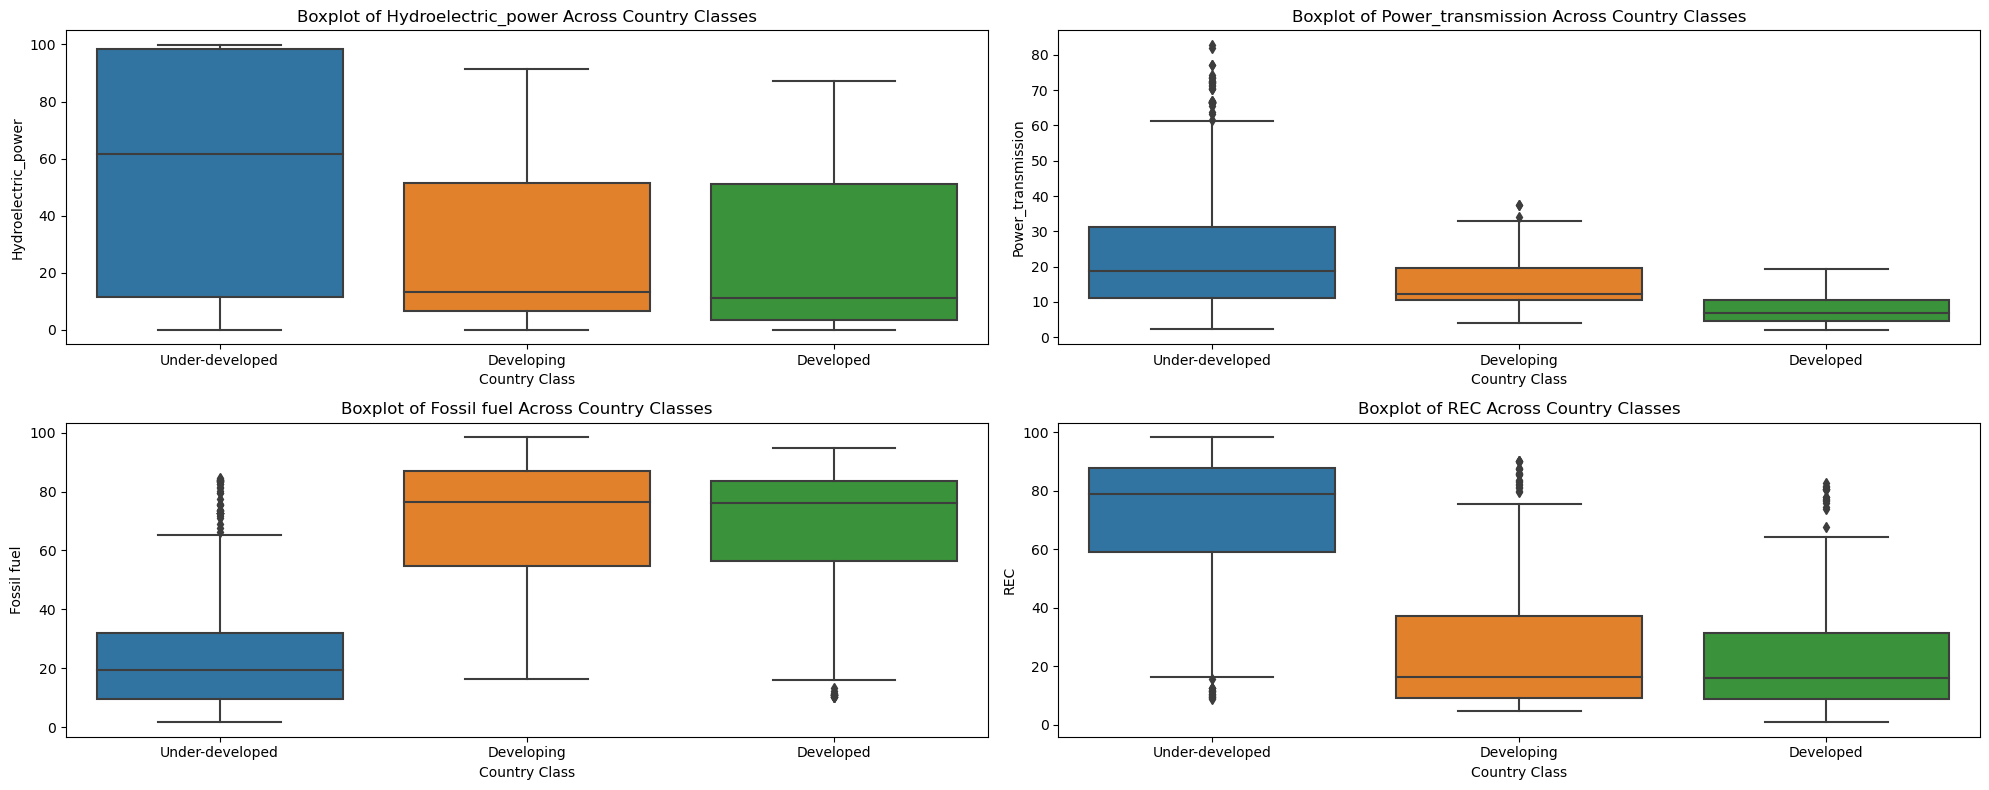

In [62]:
plt.figure(figsize=(20, 8))

for var in range(len(sdg7_indicators)):
    plt.subplot(2, 2, var+1)
    sns.boxplot(data=clean_df, x='Country Class', y=sdg7_indicators[var])
    plt.title(f'Boxplot of {sdg7_indicators[var]} Across Country Classes')
plt.tight_layout()

##### Setting up the plotting environment for Economic Health Indicators

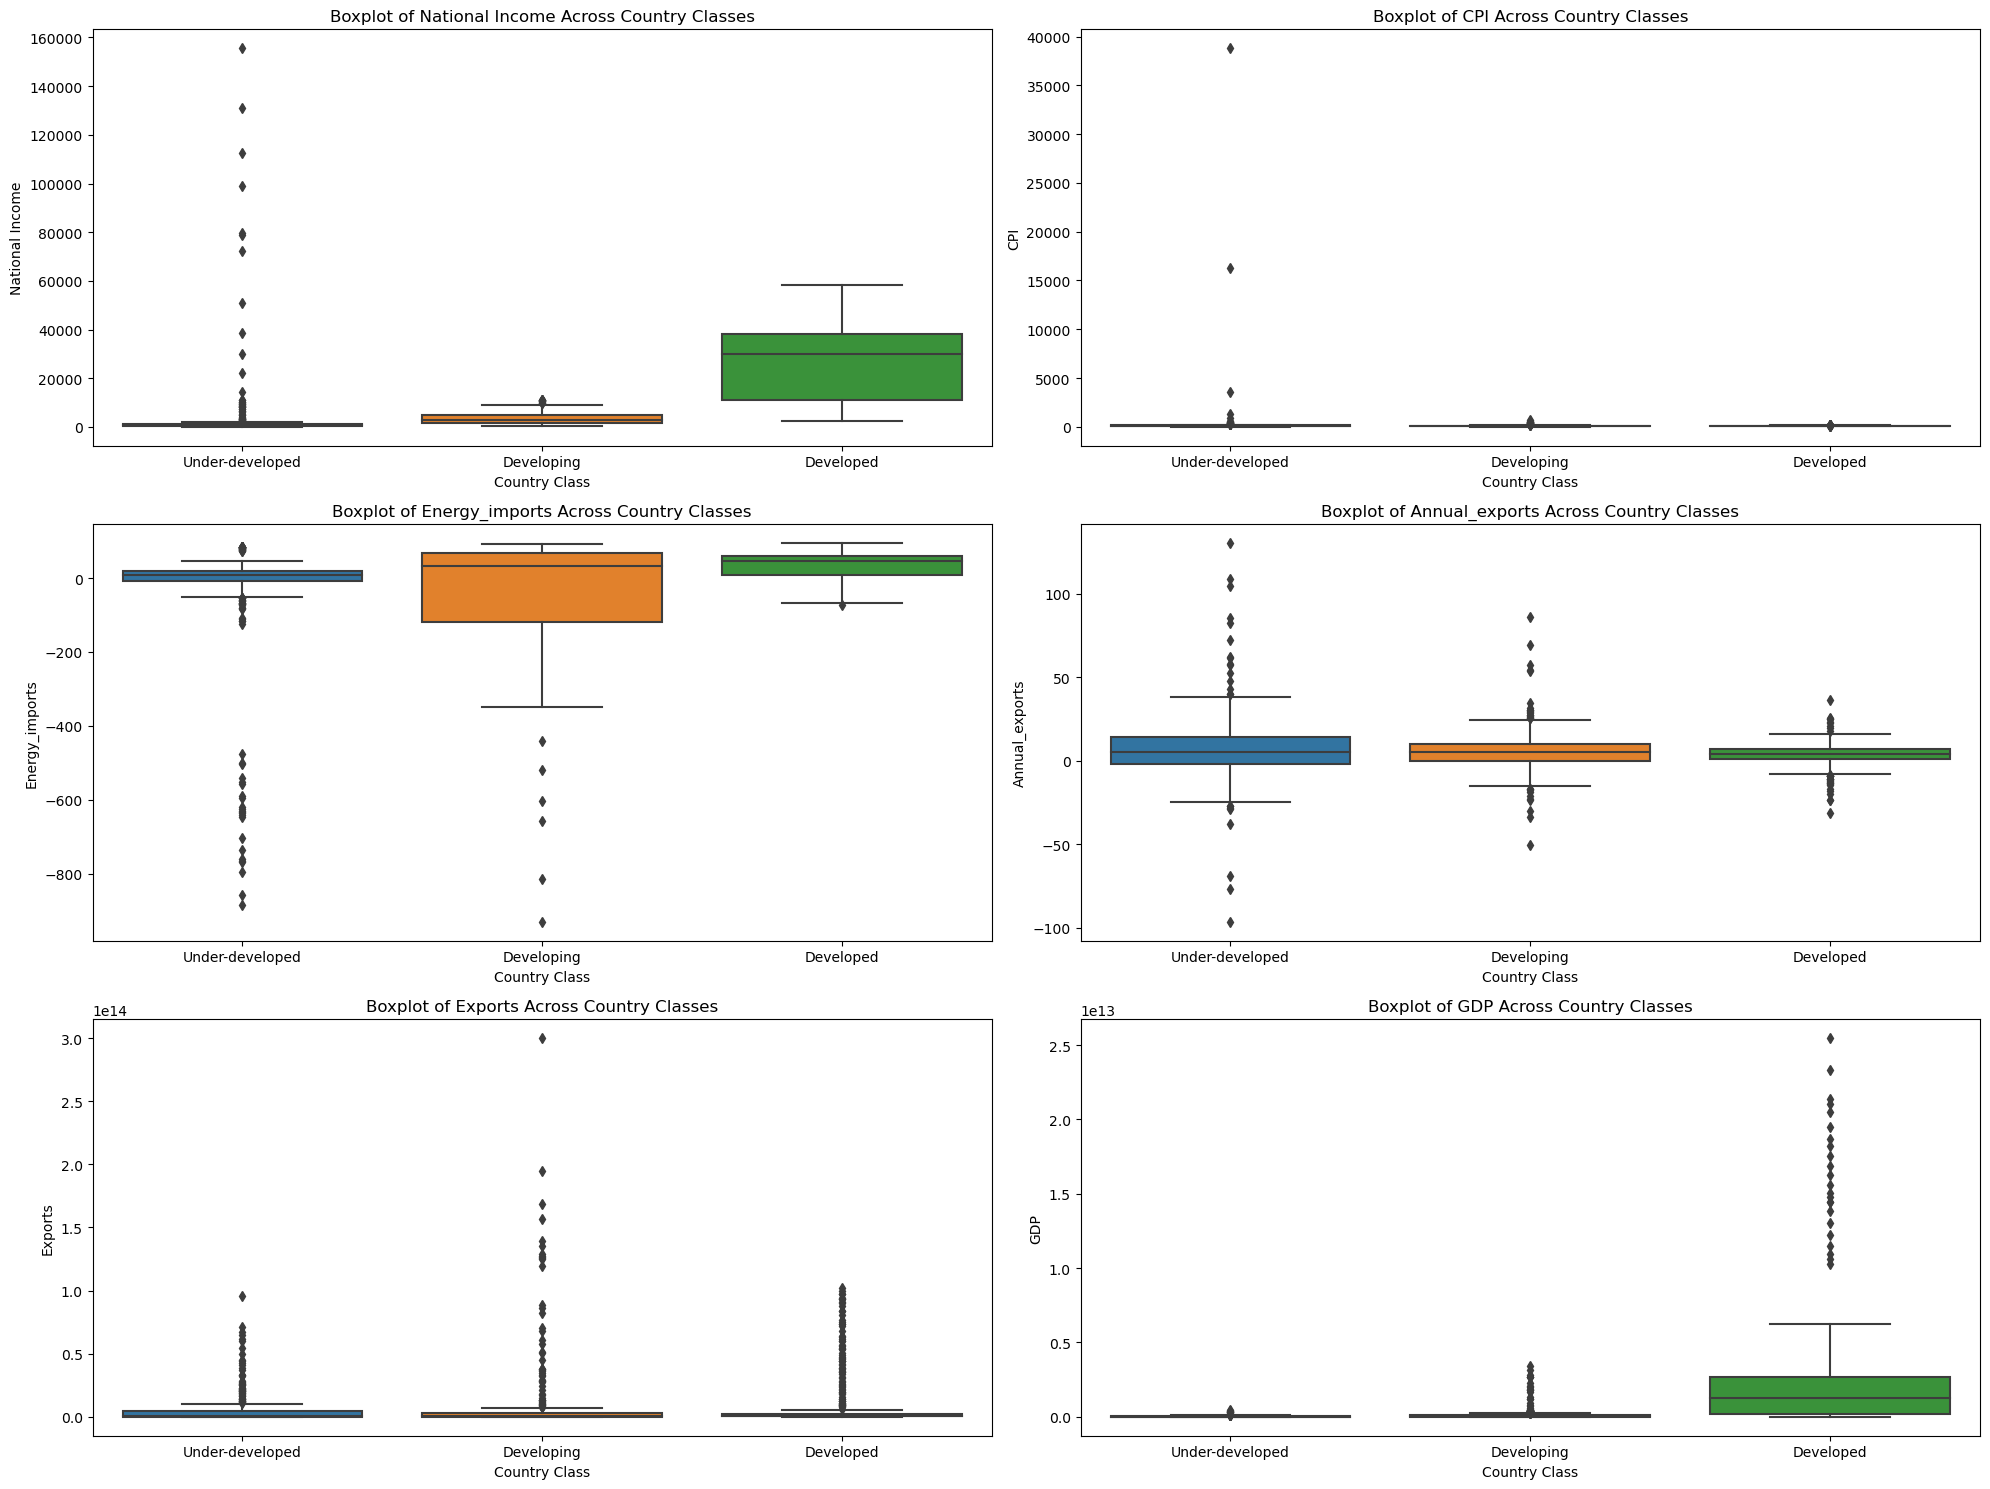

In [63]:
plt.figure(figsize=(20, 15))

for var in range(len(economic_health)):
    plt.subplot(3, 2, var+1)
    sns.boxplot(data=clean_df, x='Country Class', y=economic_health[var])
    plt.title(f'Boxplot of {economic_health[var]} Across Country Classes')
plt.tight_layout()

## Objective 2

##### Correlation Analysis

First, Identify the SDG 7 Indicators and Economic Health Indicators

In [64]:
sdg7_indicators=[
    'Hydroelectric_power', 'Power_transmission', 
    'Fossil fuel','REC'
]

economic_health=[
    'National Income', 'CPI',
    'Energy_imports', 'Annual_exports', 'Exports','GDP'
]

### Correlation

In [66]:
corelation_matrices={}

for country in clean_df['Country Class'].unique():
    cor_mat=clean_df[clean_df['Country Class'] == country][sdg7_indicators+economic_health].corr()

In [67]:
cor_mat

Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
Series Name,,,,,,,,,,
Hydroelectric_power,1.000000,0.328731,-0.573524,0.771945,-0.220047,0.008355,-0.261702,0.004692,-0.183434,-0.287222
Power_transmission,0.328731,1.000000,0.217648,-0.005790,-0.749818,0.061241,-0.230327,0.098451,-0.164481,-0.213210
Fossil fuel,-0.573524,0.217648,1.000000,-0.854426,-0.227332,-0.072231,0.032167,0.010267,0.226642,0.287059
REC,0.771945,-0.005790,-0.854426,1.000000,0.087014,0.141496,-0.149307,-0.017030,-0.220098,-0.354180
National Income,-0.220047,-0.749818,-0.227332,0.087014,1.000000,0.095128,-0.136273,-0.140975,-0.168414,0.389550
CPI,0.008355,0.061241,-0.072231,0.141496,0.095128,1.000000,-0.005182,-0.153811,0.132349,0.085781
Energy_imports,-0.261702,-0.230327,0.032167,-0.149307,-0.136273,-0.005182,1.000000,0.052919,0.441675,0.023439
Annual_exports,0.004692,0.098451,0.010267,-0.017030,-0.140975,-0.153811,0.052919,1.000000,0.007767,-0.066665
Exports,-0.183434,-0.164481,0.226642,-0.220098,-0.168414,0.132349,0.441675,0.007767,1.000000,0.046872


##### Select the SDG 7 variables and Economic health Variables

In [68]:
corelation_matrices={}

for country in clean_df['Country Class'].unique():
    cor_mat=clean_df[clean_df['Country Class'] == country][sdg7_indicators+economic_health].corr(method='kendall')
    corelation_matrices[country]=cor_mat.iloc[:4, -6:]

In [69]:
 corelation_matrices[country]

Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
Series Name,,,,,,
Hydroelectric_power,-0.176879,0.005583,-0.080721,-0.034378,-0.231884,-0.276778
Power_transmission,-0.485575,-0.016479,-0.166633,0.025581,-0.070475,-0.136940
Fossil fuel,-0.104382,-0.121324,0.090125,0.010954,0.178800,0.299461
REC,-0.002326,0.153703,-0.154764,-0.038969,-0.193093,-0.438807


### Correlation Plot For Underdeveloped countries

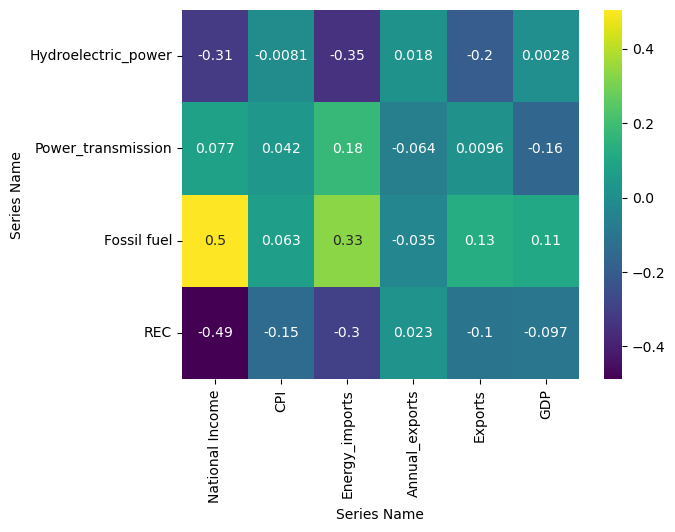

In [70]:
sns.heatmap(corelation_matrices['Under-developed'], annot=True, cmap='viridis');

In [71]:
corelation_matrices['Under-developed']

Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
Series Name,,,,,,
Hydroelectric_power,-0.314627,-0.008066,-0.346257,0.018226,-0.199135,0.002782
Power_transmission,0.077182,0.042218,0.176508,-0.063600,0.009572,-0.160566
Fossil fuel,0.504550,0.062964,0.331008,-0.034547,0.125784,0.105359
REC,-0.488574,-0.145690,-0.298773,0.023291,-0.104827,-0.097243


### Correlation Plot For Developing countries

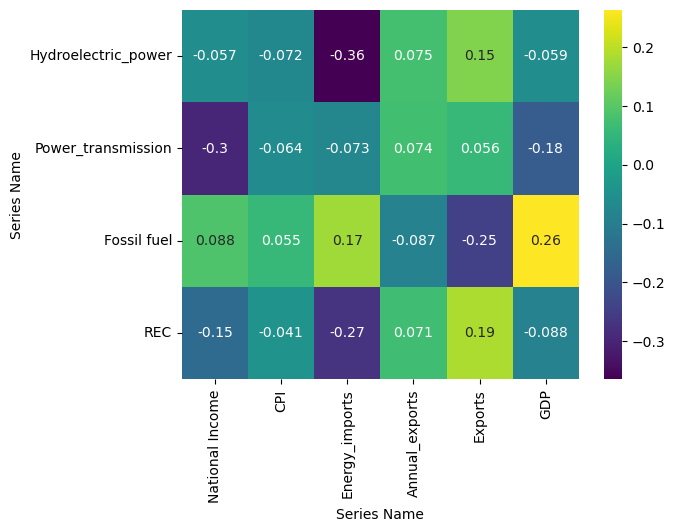

In [72]:
sns.heatmap(corelation_matrices['Developing'], annot=True, cmap='viridis');

In [73]:
corelation_matrices['Developing']

Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
Series Name,,,,,,
Hydroelectric_power,-0.057382,-0.071651,-0.364900,0.075178,0.145384,-0.059337
Power_transmission,-0.298517,-0.064449,-0.073037,0.074317,0.055982,-0.183047
Fossil fuel,0.087833,0.055475,0.174115,-0.087361,-0.245501,0.263431
REC,-0.147405,-0.041042,-0.270372,0.070821,0.187012,-0.088416


### Correlation Plot For Developed countries

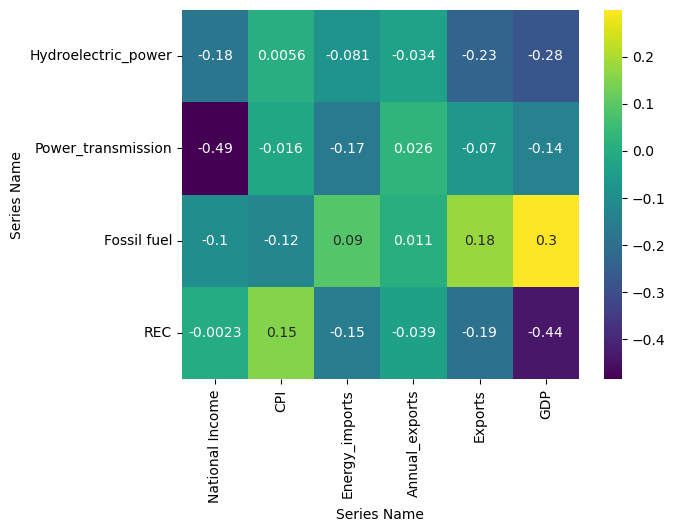

In [75]:
sns.heatmap(corelation_matrices['Developed'], annot=True, cmap='viridis');

In [76]:
corelation_matrices['Developed']

Series Name,National Income,CPI,Energy_imports,Annual_exports,Exports,GDP
Series Name,,,,,,
Hydroelectric_power,-0.176879,0.005583,-0.080721,-0.034378,-0.231884,-0.276778
Power_transmission,-0.485575,-0.016479,-0.166633,0.025581,-0.070475,-0.136940
Fossil fuel,-0.104382,-0.121324,0.090125,0.010954,0.178800,0.299461
REC,-0.002326,0.153703,-0.154764,-0.038969,-0.193093,-0.438807


## Objective 3: Cluster Analysis

The approach involves utilizing the median per country. With this, one country does not exist in more than one cluster due to the different years. The process follows these steps:

1. Implementing a power transformation on the data to enhance clusterability.
2. Employing TSNE to reduce the data to a two-dimensional form.
3. Determining the optimal number of clusters through the elbow method.

In [78]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer

In [91]:
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [79]:
for_clustering=clean_df[sdg7_indicators+['Country Name', 'Country Class']]
for_clustering.head()

Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC,Country Name,Country Class
0,63.114187,14.602076,25.220052,73.44,Angola,Under-developed
1,62.087912,14.529915,26.679300,72.34,Angola,Under-developed
2,64.759207,14.617564,28.147804,70.42,Angola,Under-developed
3,62.205514,12.932331,31.721424,65.14,Angola,Under-developed
4,78.405018,26.433692,31.561637,61.92,Angola,Under-developed


##### CREATE NEW DATAFRAME FOR CLUSTERING

In [81]:
for_clustering=clean_df[sdg7_indicators+['Country Name', 'Country Class']]
for_clustering.head()

Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC,Country Name,Country Class
0,63.114187,14.602076,25.220052,73.44,Angola,Under-developed
1,62.087912,14.529915,26.679300,72.34,Angola,Under-developed
2,64.759207,14.617564,28.147804,70.42,Angola,Under-developed
3,62.205514,12.932331,31.721424,65.14,Angola,Under-developed
4,78.405018,26.433692,31.561637,61.92,Angola,Under-developed


##### GROUP BY COUNTRY NAME AND SELECT THE MEDIAN VALUES

In [82]:
df=for_clustering.groupby('Country Name').median()[['Hydroelectric_power', 'Power_transmission', 'Fossil fuel', 'REC']]

In [90]:
for_clustering=clean_df[sdg7_indicators+['Country Name']]
df=for_clustering.groupby('Country Name').median()
df.head()

Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC
Country Name,,,,
Angola,63.371310,11.270691,41.799331,54.88
Armenia,28.627596,12.207566,73.286133,8.38
Bangladesh,1.682982,11.577120,71.648839,38.44
Belarus,0.144851,10.607167,91.492953,7.20
Benin,0.500282,66.623882,36.865053,51.05


##### APPLY POWER TRANSFORMATION - yeo-johnson

In [92]:
# Get PowerTransformer and TSNE done

transformation_pipeline = Pipeline(steps=[
    ('Transform', PowerTransformer(method ='yeo-johnson', standardize = False)),
    ('tsne', TSNE(n_components=2, random_state=42, perplexity=10)),
    ])
transformation_pipeline

Pipeline(steps=[('Transform', PowerTransformer(standardize=False)),
                ('tsne', TSNE(perplexity=10, random_state=42))])

In [104]:
tsne_components = transformation_pipeline.fit_transform(df)
tsne_components.head()

,tsne0,tsne1
Country Name,,
Angola,-2.866122,-5.942466
Armenia,11.498981,8.495514
Bangladesh,11.348056,7.229155
Belarus,20.284670,13.103133
Benin,-3.567251,-6.620028


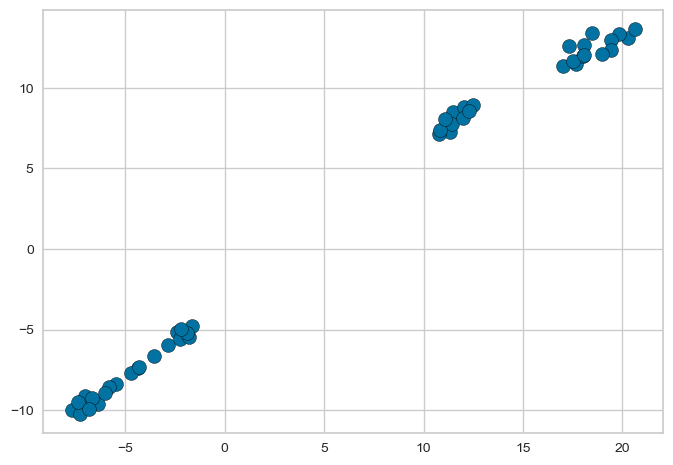

In [105]:
## plot transformation in 2D

plt.scatter(tsne_components.tsne0, tsne_components.tsne1, edgecolor='black', s=100);

There are obviously three clusters here. Let's see how many clusters the elbow method chooses.

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

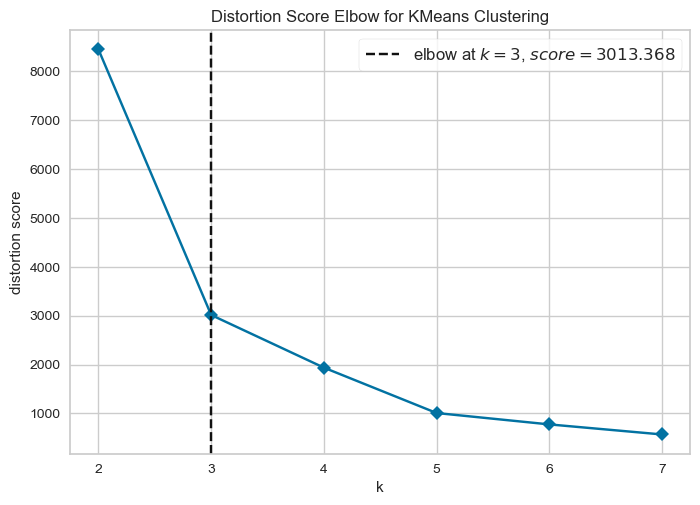

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [107]:
visualizer = KElbowVisualizer(KMeans(n_init=25), k=(2,8), timings=False)
X_logged=PowerTransformer(method ='yeo-johnson', standardize = False).fit_transform(df)
visualizer.fit(X_logged)       
visualizer.show()       

##### FIT K-MEANS

In [108]:
kmeans_pipeline = Pipeline([
    ('Transform', PowerTransformer(method ='yeo-johnson', standardize = False)),
    ('kmeans', KMeans(n_clusters=3, random_state=42, n_init=25))
])

kmeans_pipeline.fit(tsne_components)

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


Pipeline(steps=[('Transform', PowerTransformer(standardize=False)),
                ('kmeans', KMeans(n_clusters=3, n_init=25, random_state=42))])

##### GET THE CLUSTER FOR INDIVIDUAL COUNTRIES

In [109]:
clusters = pd.DataFrame(kmeans_pipeline.predict(tsne_components), columns = ['y_kmeans'])

cluster_df = pd.concat([tsne_components.reset_index(), clusters], axis = 1)
cluster_df.head()

,Country Name,tsne0,tsne1,y_kmeans
0,Angola,-2.866122,-5.942466,1
1,Armenia,11.498981,8.495514,0
2,Bangladesh,11.348056,7.229155,0
3,Belarus,20.284670,13.103133,0
4,Benin,-3.567251,-6.620028,1


##### IDENTIFY THE COUNTRY CLASS BASED ON THE CLUSTERS EACH COUNTRY FALL

In [110]:
cluster_df['Country Class'] = cluster_df['Country Name'].\
                                apply(lambda x:'Developed' if x in 
                                      developed_countries else('Developing' if x in 
                                                               developing_countries else 'Under-developed'))

cluster_df.head()

,Country Name,tsne0,tsne1,y_kmeans,Country Class
0,Angola,-2.866122,-5.942466,1,Under-developed
1,Armenia,11.498981,8.495514,0,Developing
2,Bangladesh,11.348056,7.229155,0,Under-developed
3,Belarus,20.284670,13.103133,0,Developing
4,Benin,-3.567251,-6.620028,1,Under-developed


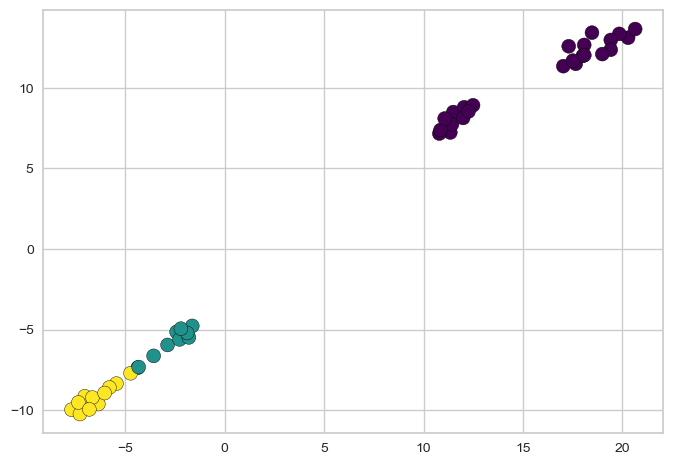

In [112]:
plt.scatter(tsne_components.tsne0, tsne_components.tsne1,c=cluster_df.y_kmeans, edgecolor='black', s=100, cmap='viridis');

##### PLOTTING

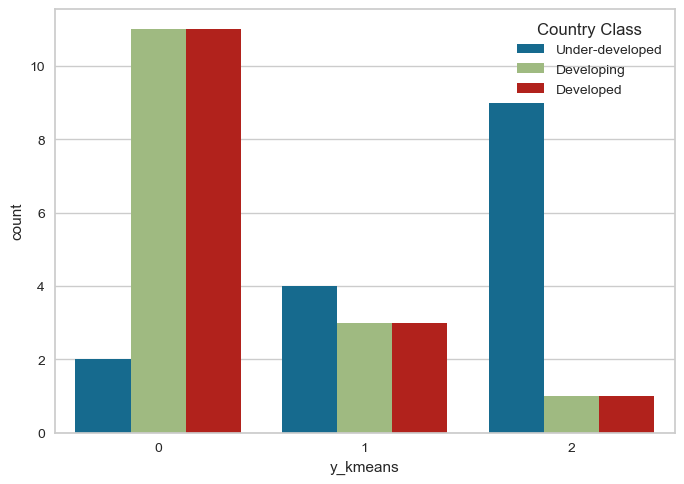

In [113]:
sns.countplot(x='y_kmeans', hue='Country Class', data=cluster_df);

##### IDENTIFY UNIQUE COUNTRIES BASED ON CLUSTERS

In [114]:
print("=========================")
print('Countries in cluster one:')
print("=========================\n")

for idx, country in enumerate(cluster_df[cluster_df.y_kmeans==0]['Country Name'].unique()):
    print(f"{idx+1}. {country}")

Countries in cluster one:

1. Armenia
2. Bangladesh
3. Belarus
4. Bolivia
5. Bulgaria
6. Canada
7. Chile
8. Colombia
9. Croatia
10. Denmark
11. Ecuador
12. Egypt, Arab Rep.
13. Germany
14. Hungary
15. India
16. Italy
17. Jamaica
18. Japan
19. Mauritius
20. Mexico
21. Morocco
22. South Africa
23. United Kingdom
24. United States


In [116]:
print("=========================")
print('Countries in cluster Two:')
print("=========================\n")

for idx, country in enumerate(cluster_df[cluster_df.y_kmeans==1]['Country Name'].unique()):
    print(f"{idx+1}. {country}")

Countries in cluster Two:

1. Angola
2. Benin
3. Brazil
4. Cambodia
5. Costa Rica
6. Finland
7. France
8. Ghana
9. Senegal
10. Sudan


In [117]:
print("===========================")
print('Countries in cluster Three:')
print("===========================\n")

for idx, country in enumerate(cluster_df[cluster_df.y_kmeans==2]['Country Name'].unique()):
    print(f"{idx+1}. {country}")

Countries in cluster Three:

1. Congo, Dem. Rep.
2. Ethiopia
3. Gabon
4. Haiti
5. Iceland
6. Mozambique
7. Myanmar
8. Nepal
9. Tanzania
10. Togo
11. Zambia


### Computing Silhouette Score

In [119]:
sil_score=silhouette_score(tsne_components, cluster_df.y_kmeans)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.7229871153831482


## Objective 4

##### Assess the association between the SDG 7 indicators and NATIONAL INCOME based on a country’s level of development.

* Step 1: build a model Regression Model.
* Association of the sdg7 vaiables from the developed model (shap)

The relationship is not linear! Other possible models apart from linear regression are:

1. Polynomial regression
2. SVM
3. XGBoost
4. Random Forest

##### Association of the SDG 7 indicators on GDP

First, create the country class variable to be the X variable

In [122]:
X,y = clean_df[sdg7_indicators+ ['Country Class']], clean_df['National Income']

In [123]:
X

Series Name,Hydroelectric_power,Power_transmission,Fossil fuel,REC,Country Class
0,63.114187,14.602076,25.220052,73.440000,Under-developed
1,62.087912,14.529915,26.679300,72.340000,Under-developed
2,64.759207,14.617564,28.147804,70.420000,Under-developed
3,62.205514,12.932331,31.721424,65.140000,Under-developed
4,78.405018,26.433692,31.561637,61.920000,Under-developed
...,...,...,...,...,...
18,98.555216,13.963452,9.297957,81.870000,Under-developed
19,98.550542,13.969789,9.295757,81.480000,Under-developed
20,98.655624,14.233077,9.168509,81.840000,Under-developed
21,98.696189,14.347207,9.112451,81.974480,Under-developed


###### The y variable is the GDP for all the countries 

In [124]:
y

0      208.216262
1      266.611472
2      567.271009
3      671.205245
4      693.447951
         ...     
18    1145.844603
19     990.129619
20     733.301291
21     964.596314
22     940.905895
Name: National Income, Length: 1035, dtype: float64

In [126]:
X,y = clean_df[sdg7_indicators+ ['Country Class']], clean_df['National Income']

encoder=OneHotEncoder(sparse_output=False)
country_encoder=encoder.fit_transform(X[['Country Class']])

X=X.drop('Country Class', axis=1)
X=pd.concat([X, country_encoder], axis=1)

X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Fit the Random Forest model

rf_param_grid = {
    'n_estimators':[50, 100, 200, 300, 500, 1000],
    'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    'max_depth': [5, 7, None]
}

final_model=GridSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    param_grid=rf_param_grid,
    n_jobs=-1, refit=True, cv=5
)
final_model.fit(X_train_dev, y_train_dev)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_depth': [5, 7, None],
                         'n_estimators': [50, 100, 200, 300, 500, 1000]})

##### Print Best Model

In [127]:
# Extract the best estimator from GridSearchCV
print("===========\nBest Model: \n===========")
best_rf=final_model.best_estimator_;best_rf

Best Model: 


RandomForestRegressor(criterion='absolute_error', n_estimators=50, n_jobs=-1,
                      random_state=42)

##### Print Best Hyper parameter

In [128]:
print("=====================\nBest Hyperparameters: \n=====================\n")
for index, (key, value) in enumerate(final_model.best_params_.items()):
    print(f'{index+1}. Best {key}: {value}')

Best Hyperparameters: 

1. Best criterion: absolute_error
2. Best max_depth: None
3. Best n_estimators: 50


### Shap Explanation

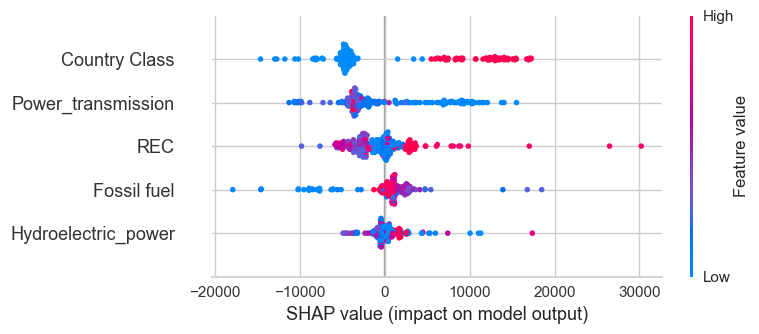

In [129]:
# Create an explainer object. 
explainer=shap.TreeExplainer(best_rf)

# Obtain Shap values
shap_values=explainer(X_test_dev)
initial_shap_values=shap_values.values.copy()

#sum shap values for the one-hot encoded features
country_class_vars=[i for i, col in enumerate(X_train_dev.columns) if "Country" in col]
country_class_shap_raw=initial_shap_values[:, country_class_vars]
country_class_shap=country_class_shap_raw.sum(axis=1)

# replace the one-hot encoded shap values with their sum
initial_shap_values[:, country_class_vars[0]] = country_class_shap
initial_shap_values=np.delete(initial_shap_values, country_class_vars[1:], axis=1)

# Update column names
updated_feature_names = [col for i, col in enumerate(X_train_dev.columns) if i not in country_class_vars[1:]]

# plot shap
shap.summary_plot(
    initial_shap_values, 
    X_test_dev[updated_feature_names].rename(columns=lambda x: "Country Class" if 'Country' in x else x)
)

##### A look into the shap values of the country class

In [130]:
box_plot_df=(
    pd.DataFrame(country_class_shap_raw, columns=X_train_dev.columns[country_class_vars])
    .melt(value_vars=X_train_dev.columns[country_class_vars])
    .rename(columns={
        'variable': 'country_class',
        'value': 'shap_value'
    })
    .assign(country_class=lambda df: df.country_class.str.replace("Country Class_", ""))
)
box_plot_df.head()

,country_class,shap_value
0,Developed,-4959.103749
1,Developed,14490.470818
2,Developed,-4413.251105
3,Developed,7320.011167
4,Developed,-4360.644727


##### BOX PLOT

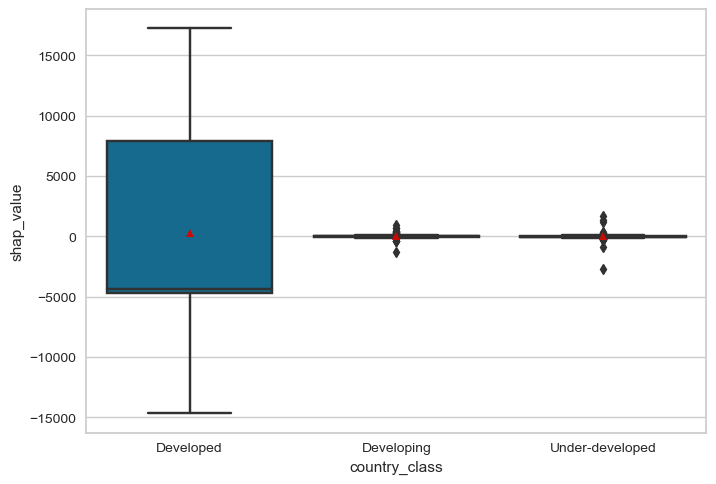

In [131]:
sns.boxplot(x='country_class', y='shap_value', data=box_plot_df, showmeans=True);

## Objective 5

Predict the proportion of energy obtained from renewable sources based on the level of development in a country.



In [132]:
## The ANOVA approach

clean_df = clean_df.rename(columns={"Country Class": "Country_Class"})

# Define the model
model = ols('REC ~ C(Country_Class)', data=clean_df).fit()

# Perform one-way ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # typ=2 for type II ANOVA

print(anova_table)


                         sum_sq      df           F         PR(>F)
C(Country_Class)  507434.384134     2.0  581.849946  6.413069e-170
Residual          450006.301723  1032.0         NaN            NaN


##### Plotting Average REC for each country class

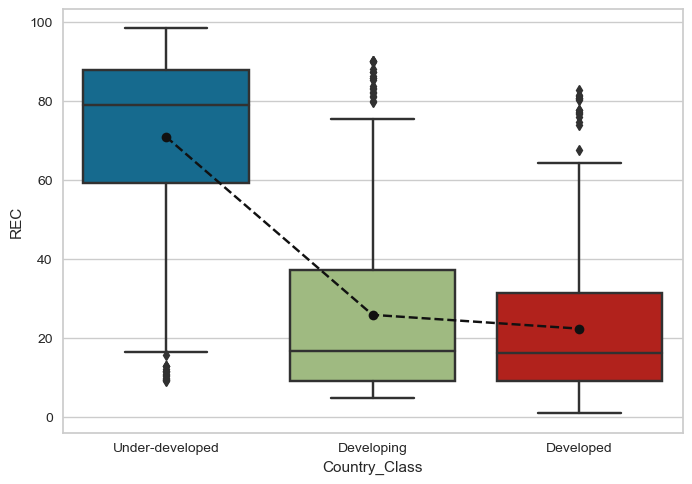

In [133]:
x=clean_df[['REC', 'Country_Class']].groupby('Country_Class').mean().sort_values(by='REC', ascending=False).index
y=clean_df[['REC', 'Country_Class']].groupby('Country_Class').mean().sort_values(by='REC', ascending=False).values

sns.boxplot(x='Country_Class', y='REC', data=clean_df)
plt.plot(x, y, 'ok--')
plt.show()

In [134]:
for j in range(3):
    print(f'Country Class: {x[j]} (mean={y[j]})')

Country Class: Under-developed (mean=[70.91846386])
Country Class: Developing (mean=[25.79273042])
Country Class: Developed (mean=[22.29820685])


##### Tukey's HSD test

In [135]:
# The ANOVA is significant, conduct Tukey's HSD test:

posthoc = pairwise_tukeyhsd(clean_df['REC'], clean_df['Country_Class'], alpha=0.05)
print(posthoc)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1        group2     meandiff p-adj  lower   upper  reject
----------------------------------------------------------------
 Developed      Developing   3.4945 0.072 -0.2372  7.2262  False
 Developed Under-developed  48.6203   0.0 44.8886 52.3519   True
Developing Under-developed  45.1257   0.0  41.394 48.8574   True
----------------------------------------------------------------


In [136]:
print(f"R-squared: {model.rsquared:.2}")

R-squared: 0.53


$R^2$ of 0.53 indicates that there are other factors responsible for determining `Renewable Energy Consumption` other than country class. We'd add more variableble and go the machine learning route. We'll compare three ensemble models:

1. Random Forest
2. Extra Trees
3. XGBoost

In [137]:
numeric=sdg7_indicators[:-1] + ['Energy_imports']
cat_col=['Country_Class']

X,y = clean_df[numeric+cat_col], clean_df['REC']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42, stratify= X['Country_Class']
)

In [138]:
def create_preprocessor(encoder):
    numeric_pipeline=Pipeline(steps=[
        ('select_numeric_cols', FunctionTransformer(lambda df:df[numeric])), ## Selecting the numeric columns 
    ])

    categorical_pipeline=Pipeline(steps=[
        ('select_cat_features', FunctionTransformer(lambda df:df[cat_col])), 
        ('encoder', encoder)
    ])

    feature_engineering= FeatureUnion([
       ('cat_pipeline', categorical_pipeline),
       ('numeric_pipeline', numeric_pipeline)
    ])
    return feature_engineering


In [139]:
def train_and_evaluate_models(ensemble, parameters, cv=5): 
    results = []
    encoders=[
        ce.OneHotEncoder(), ce.OrdinalEncoder(),
        ce.TargetEncoder(min_samples_leaf=20, smoothing=10)
    ]
    for encoder in encoders:
        preprocess_pipeline = create_preprocessor(encoder)
        model = Pipeline(steps=[
                ('feature_engineering', preprocess_pipeline),
                ('crossvalidate', GridSearchCV(ensemble, parameters,cv=cv, 
                refit=True, verbose=1,n_jobs=-1)) ])
        model.fit(X_train, y_train)
        best_model=model.named_steps['crossvalidate'].best_params_
        ## Make prediction
        ypred_train = model.predict(X_train)
        ypred_test = model.predict(X_test)
        print('=====================')
        print(f'(1.) Encoder = {encoder.__class__.__name__}') 
        print(f'(2.) Ensemble = {ensemble.__class__.__name__}')
        print(f'(3.) Best Estimator = {best_model}') 
        print('=====================\n')
        res = {
            'Encoder': encoder.__class__.__name__,
            'Ensemble': ensemble.__class__.__name__,
            'Train r2': r2_score(y_train, ypred_train),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, ypred_train)),
            'Train MAE': mean_absolute_error(y_train, ypred_train),
            'Train MAPE': mean_absolute_percentage_error(y_train,ypred_train)*100,
            'Test r2': r2_score(y_test, ypred_test),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, ypred_test)),
            'Test MAE': mean_absolute_error(y_test, ypred_test),
            'Test MAPE': mean_absolute_percentage_error(y_test,ypred_test)*100
        } 
        results.append(res)
    results_df=pd.DataFrame(results) 
    return results_df

### Random Forest

In [140]:
ensemble = RandomForestRegressor(n_jobs=-1, random_state=SEED)
rf_param_grid = {
    'n_estimators':[50, 100, 200, 300, 500, 1000],
    'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    'max_depth': [5, 7, None]
}
rf_results = train_and_evaluate_models(ensemble, rf_param_grid, cv=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = OneHotEncoder
(2.) Ensemble = RandomForestRegressor
(3.) Best Estimator = {'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 300}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = OrdinalEncoder
(2.) Ensemble = RandomForestRegressor
(3.) Best Estimator = {'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 100}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = TargetEncoder
(2.) Ensemble = RandomForestRegressor
(3.) Best Estimator = {'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 100}



In [141]:
os.makedirs('results', exist_ok=True)

rf_results.to_csv('results/rf_results.csv', index=False)

In [142]:
rf_results

,Encoder,Ensemble,Train r2,Train RMSE,Train MAE,Train MAPE,Test r2,Test RMSE,Test MAE,Test MAPE
0,OneHotEncoder,RandomForestRegressor,0.998430,1.210452,0.757310,4.385890,0.985237,3.628922,2.380266,11.042946
1,OrdinalEncoder,RandomForestRegressor,0.998301,1.259377,0.779827,4.499456,0.984702,3.694033,2.410912,11.381279
2,TargetEncoder,RandomForestRegressor,0.998304,1.258030,0.775982,4.480589,0.984775,3.685241,2.404811,11.003511


### Extra Trees

In [143]:
ensemble = ExtraTreesRegressor(n_jobs=-1, random_state=42)
ext_results = train_and_evaluate_models(ensemble, rf_param_grid, cv=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = OneHotEncoder
(2.) Ensemble = ExtraTreesRegressor
(3.) Best Estimator = {'criterion': 'squared_error', 'max_depth': None, 'n_estimators': 500}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = OrdinalEncoder
(2.) Ensemble = ExtraTreesRegressor
(3.) Best Estimator = {'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 1000}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
(1.) Encoder = TargetEncoder
(2.) Ensemble = ExtraTreesRegressor
(3.) Best Estimator = {'criterion': 'friedman_mse', 'max_depth': None, 'n_estimators': 300}



In [144]:
ext_results

,Encoder,Ensemble,Train r2,Train RMSE,Train MAE,Train MAPE,Test r2,Test RMSE,Test MAE,Test MAPE
0,OneHotEncoder,ExtraTreesRegressor,1.0,3.311492e-13,2.273408e-13,5.956209e-13,0.990497,2.911517,1.711292,7.485267
1,OrdinalEncoder,ExtraTreesRegressor,1.0,6.781891e-13,4.752198e-13,1.238579e-12,0.990224,2.952992,1.738586,7.635400
2,TargetEncoder,ExtraTreesRegressor,1.0,2.177109e-13,1.497281e-13,3.599577e-13,0.990620,2.892576,1.700376,7.558942


In [145]:
ext_results.to_csv('results/ext_results.csv', index=False)

### XG Boost

In [146]:
ensemble = xgb.XGBRegressor(eval_metric=mean_squared_error, n_jobs=-1) 
parameters = {
    'max_depth': [None, 3, 5, 7],
    'n_estimators': [200, 500, 1000],
    'learning_rate': 2**np.arange(-8., 2., step=3),
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:pseudohubererror'],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}
xgb_results = train_and_evaluate_models(ensemble, parameters, cv=5)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
(1.) Encoder = OneHotEncoder
(2.) Ensemble = XGBRegressor
(3.) Best Estimator = {'learning_rate': 0.25, 'max_depth': None, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0.1}

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
(1.) Encoder = OrdinalEncoder
(2.) Ensemble = XGBRegressor
(3.) Best Estimator = {'learning_rate': 0.03125, 'max_depth': None, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 0}

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
(1.) Encoder = TargetEncoder
(2.) Ensemble = XGBRegressor
(3.) Best Estimator = {'learning_rate': 0.03125, 'max_depth': None, 'n_estimators': 500, 'objective': 'reg:squarederror', 'reg_alpha': 0.01, 'reg_lambda': 0.01}



In [148]:
xgb_results

,Encoder,Ensemble,Train r2,Train RMSE,Train MAE,Train MAPE,Test r2,Test RMSE,Test MAE,Test MAPE
0,OneHotEncoder,XGBRegressor,0.999995,0.069656,0.053327,0.357199,0.984772,3.685658,2.311231,9.994536
1,OrdinalEncoder,XGBRegressor,0.999957,0.201130,0.152389,0.927683,0.985718,3.569256,2.241867,10.466820
2,TargetEncoder,XGBRegressor,0.999758,0.475731,0.351944,2.317429,0.985333,3.617070,2.296527,10.374586


In [149]:
xgb_results.to_csv('results/xgb_results.csv', index=False)

In [150]:
final_results=pd.concat([
    xgb_results, 
    ext_results,
    rf_results
], ignore_index=True)

final_results

,Encoder,Ensemble,Train r2,Train RMSE,Train MAE,Train MAPE,Test r2,Test RMSE,Test MAE,Test MAPE
0,OneHotEncoder,XGBRegressor,0.999995,6.965645e-02,5.332655e-02,3.571986e-01,0.984772,3.685658,2.311231,9.994536
1,OrdinalEncoder,XGBRegressor,0.999957,2.011297e-01,1.523890e-01,9.276827e-01,0.985718,3.569256,2.241867,10.466820
2,TargetEncoder,XGBRegressor,0.999758,4.757307e-01,3.519439e-01,2.317429e+00,0.985333,3.617070,2.296527,10.374586
3,OneHotEncoder,ExtraTreesRegressor,1.000000,3.311492e-13,2.273408e-13,5.956209e-13,0.990497,2.911517,1.711292,7.485267
4,OrdinalEncoder,ExtraTreesRegressor,1.000000,6.781891e-13,4.752198e-13,1.238579e-12,0.990224,2.952992,1.738586,7.635400
5,TargetEncoder,ExtraTreesRegressor,1.000000,2.177109e-13,1.497281e-13,3.599577e-13,0.990620,2.892576,1.700376,7.558942
6,OneHotEncoder,RandomForestRegressor,0.998430,1.210452e+00,7.573102e-01,4.385890e+00,0.985237,3.628922,2.380266,11.042946
7,OrdinalEncoder,RandomForestRegressor,0.998301,1.259377e+00,7.798267e-01,4.499456e+00,0.984702,3.694033,2.410912,11.381279
8,TargetEncoder,RandomForestRegressor,0.998304,1.258030e+00,7.759818e-01,4.480589e+00,0.984775,3.685241,2.404811,11.003511


##### PLOTTING FOR EACH MODEL 

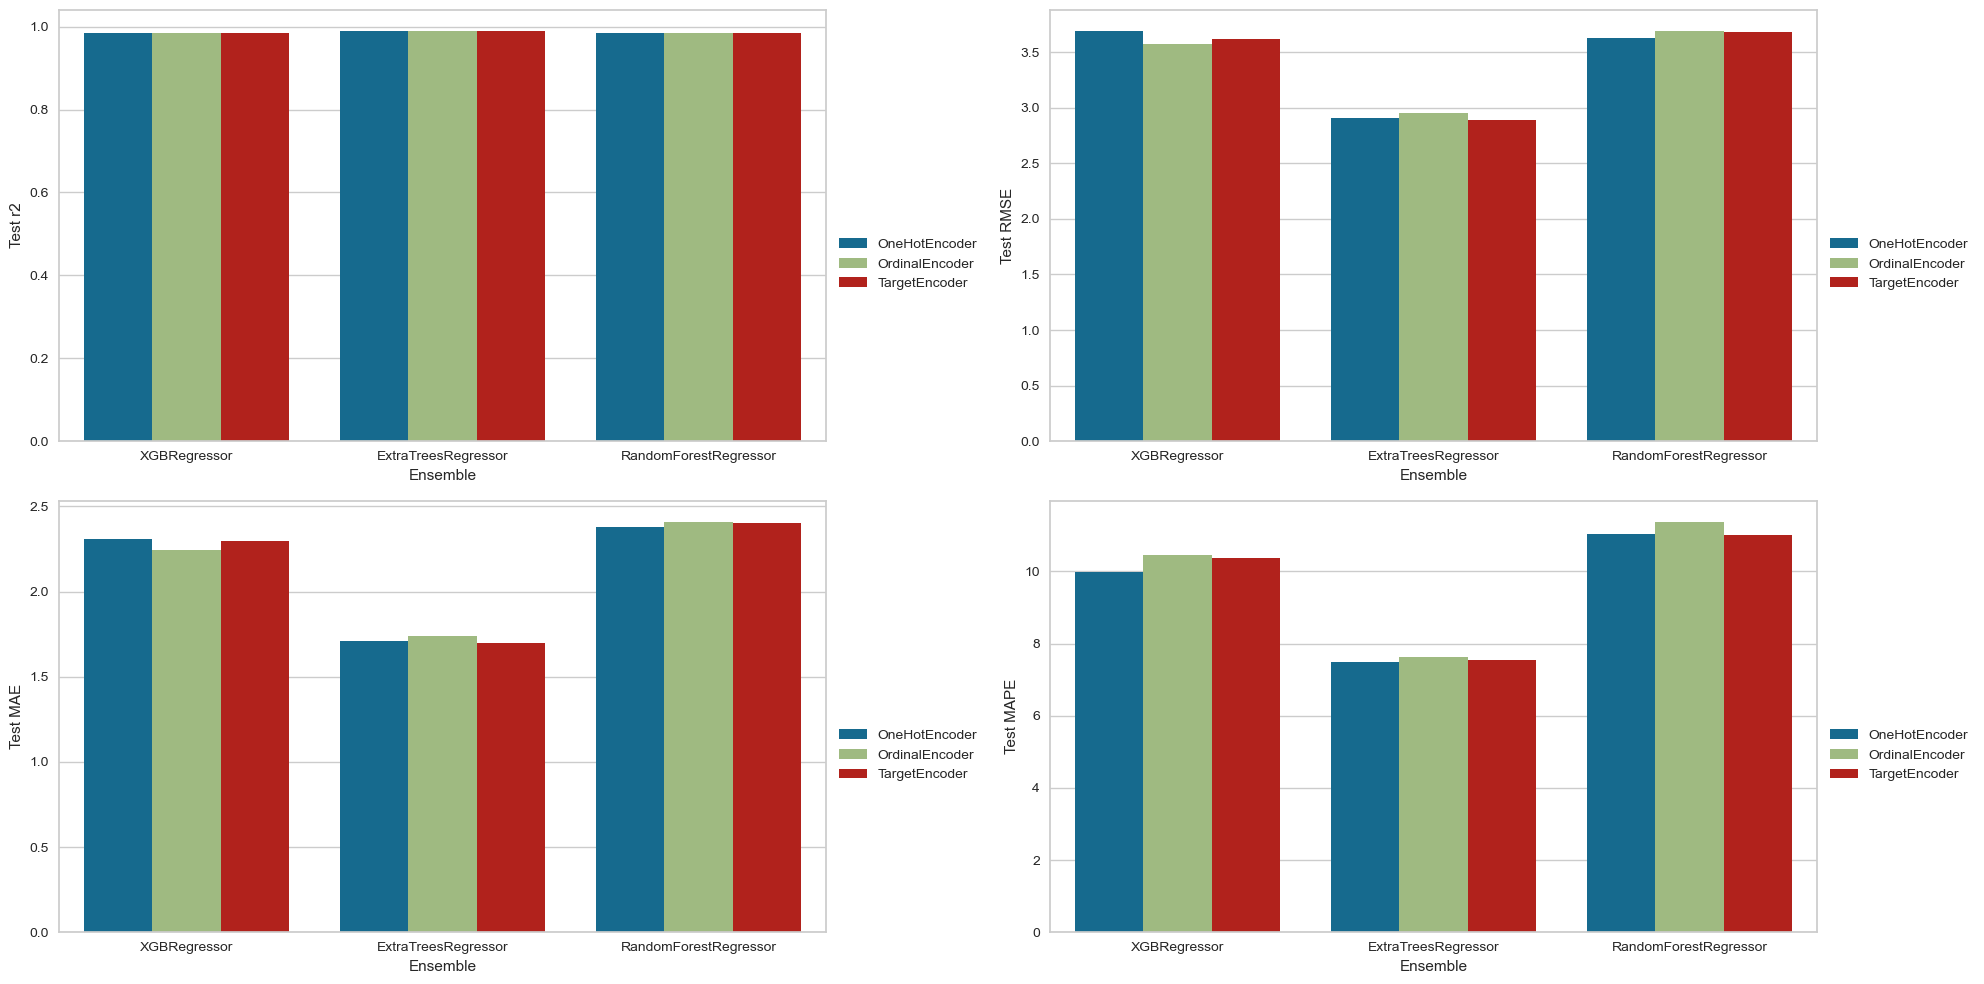

In [151]:
tests=[
    'Test r2', 'Test RMSE',
    'Test MAE', 'Test MAPE'
]
plt.figure(figsize=(20,10))


for j in range(4):
    plt.subplot(2, 2, j+1)
    sns.barplot(data=final_results, x='Ensemble', y=tests[j], hue='Encoder')
    plt.legend(bbox_to_anchor=(1, 0.5))
plt.tight_layout()


In [152]:
## compare models using RMSE

final_results.to_csv('results/all_results.csv', index=False)


# Group the data by 'Ensemble' and 'Encoder', and find the combination that yields the smallest Test RMSE score for each Ensemble
best_test_r2_by_ensemble = final_results.groupby('Ensemble').apply(lambda x: x.nsmallest(1, 'Test RMSE')).reset_index(drop=True)

# Sort the result by 'Test r2' in descending order
best = best_test_r2_by_ensemble.sort_values('Test r2', ascending=False)

best


,Encoder,Ensemble,Train r2,Train RMSE,Train MAE,Train MAPE,Test r2,Test RMSE,Test MAE,Test MAPE
0,TargetEncoder,ExtraTreesRegressor,1.000000,2.177109e-13,1.497281e-13,3.599577e-13,0.990620,2.892576,1.700376,7.558942
2,OrdinalEncoder,XGBRegressor,0.999957,2.011297e-01,1.523890e-01,9.276827e-01,0.985718,3.569256,2.241867,10.466820
1,OneHotEncoder,RandomForestRegressor,0.998430,1.210452e+00,7.573102e-01,4.385890e+00,0.985237,3.628922,2.380266,11.042946


##### COMPARE VISUALLY 

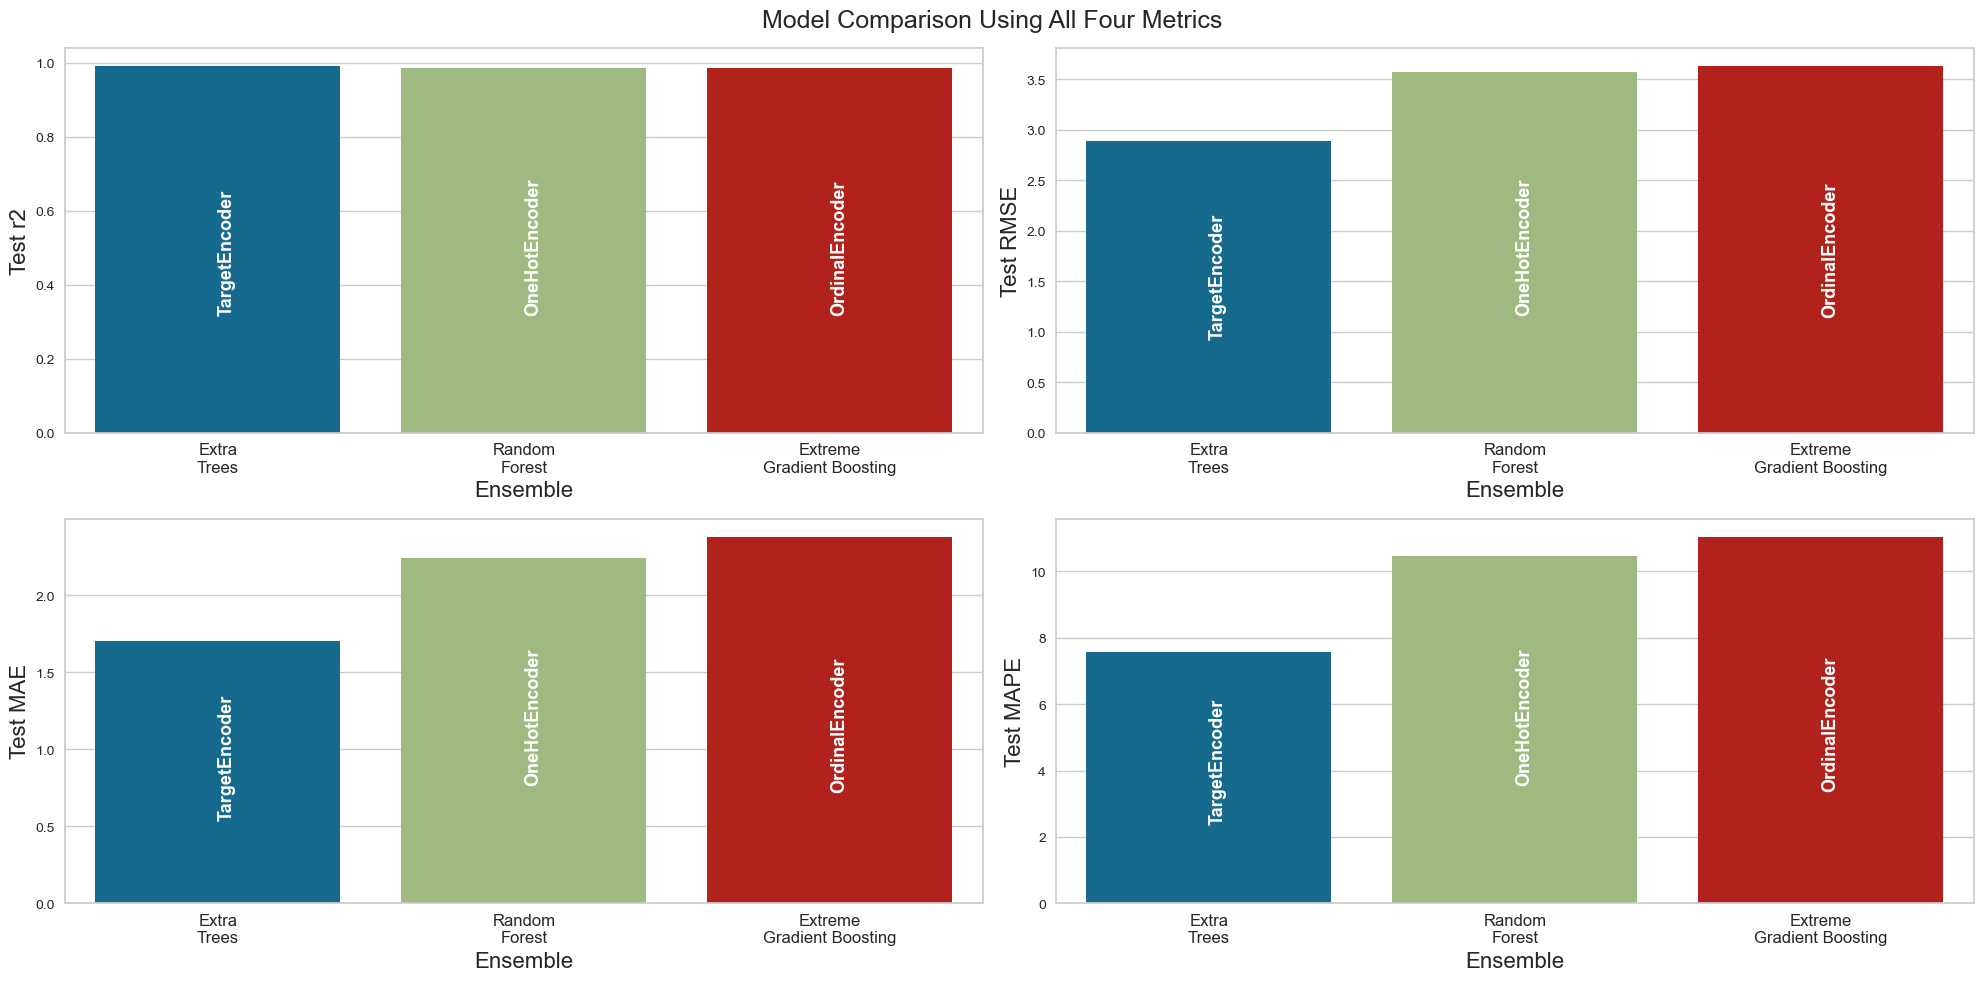

In [153]:
ticks=[
    'Extra\nTrees', 'Extreme\nGradient Boosting', 'Random\nForest'
]


metrics=['Test r2', 'Test RMSE', 'Test MAE', 'Test MAPE']


plt.figure(figsize=(20,10))
plt.suptitle('Model Comparison Using All Four Metrics', fontsize=18)
for j in range(4):
    plt.subplot(2,2, j+1)
    bar=sns.barplot(x='Ensemble', y=metrics[j], data=best)

    for i in range(len(best)):
        ec=best['Encoder'][i]
        bar.text(i, best[metrics[j]][i]/3, f'{ec}', rotation=90, fontdict={'color': 'white', 'fontsize':13, 'fontweight': 'bold'})
    plt.xticks(best.index, ticks, fontsize=12)
    plt.ylabel(metrics[j], fontsize=16)
    plt.xlabel('Ensemble', fontsize=16)
plt.tight_layout()

### Best (Extra Trees + Target Coder)

In [154]:
final_ensemble=Pipeline(steps=[
    ('feature_engineering', create_preprocessor(ce.TargetEncoder(min_samples_leaf=20, smoothing=10))),
    ('regressor', ExtraTreesRegressor(n_jobs=-1, random_state=42, criterion='friedman_mse', n_estimators=1000))
])
final_ensemble.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('select_cat_features',
                                                                  FunctionTransformer(func=<function create_preprocessor.<locals>.<lambda> at 0x00000230CCF32940>)),
                                                                 ('encoder',
                                                                  TargetEncoder(cols=['Country_Class']))])),
                                                ('numeric_pipeline',
                                                 Pipeline(steps=[('select_numeric_cols',
                                                                  FunctionTransformer(func=<function create_preprocessor.<locals>.<lambda> at 0x00000230CE6843A0>))]))])),
                ('regressor',
                 ExtraTreesRegressor(criterion='friedman_mse',
                                     n_estimators=1000, n_jobs=-1,
                                     random_state=42))])

### Feature Importance

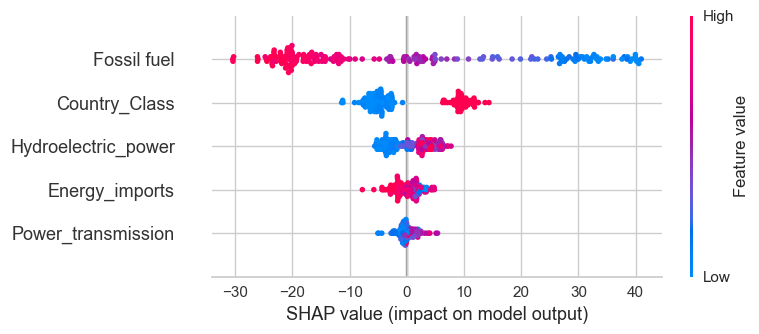

In [155]:
transformed_test = final_ensemble.named_steps['feature_engineering'].transform(X_test)

# Create SHAP explainer object
explainer = shap.Explainer(final_ensemble.named_steps['regressor'])

# Compute SHAP values for the transformed sample
shap_values = explainer.shap_values(transformed_test)

# Generate SHAP summary plot
shap.summary_plot(shap_values, transformed_test)